# Language in Space

## Session 07: Vector data operations

### Gerhard Jäger

December 9, 2021


In [1]:
options(repr.plot.width=12, repr.plot.height=9)


In [2]:
library(tidyverse)
library(sf)
library(spData)


── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Linking to GEOS 3.9.0, GDAL 3.2.2, PROJ 7.2.1



## Spatial data operations

When working with spatial data sets, we want to use the spatial information for various data processing tasks. 

### Examples

- Join a tibble with polygon geometries to a tibble with point geometries such that each polygon is joined with each point within its area.

- When summarizing observations with polygon geometries, assign the union of the geometries to the aggregated observations.

- Find all observations that are within 100 km distance of a given point.

- Form the intersection of polygons (e.g., to crop a map).

- Change the shape and location of geometries, e.g. shifting, scaling, mirroring or rotating them.



### Topological relations

Topological relations are relations between geometric objects that remain constant under continuous transformations like shifting, scaling, rotating or deforming.


**Example**

In [3]:
# create a polygon
a_poly = st_polygon(list(rbind(c(-1, -1), c(1, -1), c(1, 1), c(-1, -1))))
a = st_sfc(a_poly)

# create a second polygon

b_poly = st_polygon(list(rbind(c(0.1, -1), c(0.1, 0), c(.9, 0), c(.9, -1), c(.1, -1))))
b = st_sfc(b_poly)

# create a line
l_line = st_linestring(x = matrix(c(-1, -1, -0.5, 1), ncol = 2))
l = st_sfc(l_line)
# create points
p_matrix = matrix(c(0.5, 1, -1, 0, 0, 1, 0.5, 1), ncol = 2)
p_multi = st_multipoint(x = p_matrix)
p = st_cast(st_sfc(p_multi), "POINT")

exampleGeometries <- st_sf(
    names = c("a", "b", "l", "p1", "p2", "p3", "p4"),
    type = c("polygon", "polygon", "line", "point", "point", "point", "point"),
    c(a, b, l, p)
)
exampleGeometries

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,names,type,c.a..b..l..p.
,<chr>,<chr>,<GEOMETRY>
1,a,polygon,"POLYGON ((-1 -1, 1 -1, 1 1,..."
2,b,polygon,"POLYGON ((0.1 -1, 0.1 0, 0...."
3,l,line,"LINESTRING (-1 -0.5, -1 1)"
4,p1,point,POINT (0.5 0)
5,p2,point,POINT (1 1)
6,p3,point,POINT (-1 0.5)
7,p4,point,POINT (0 1)


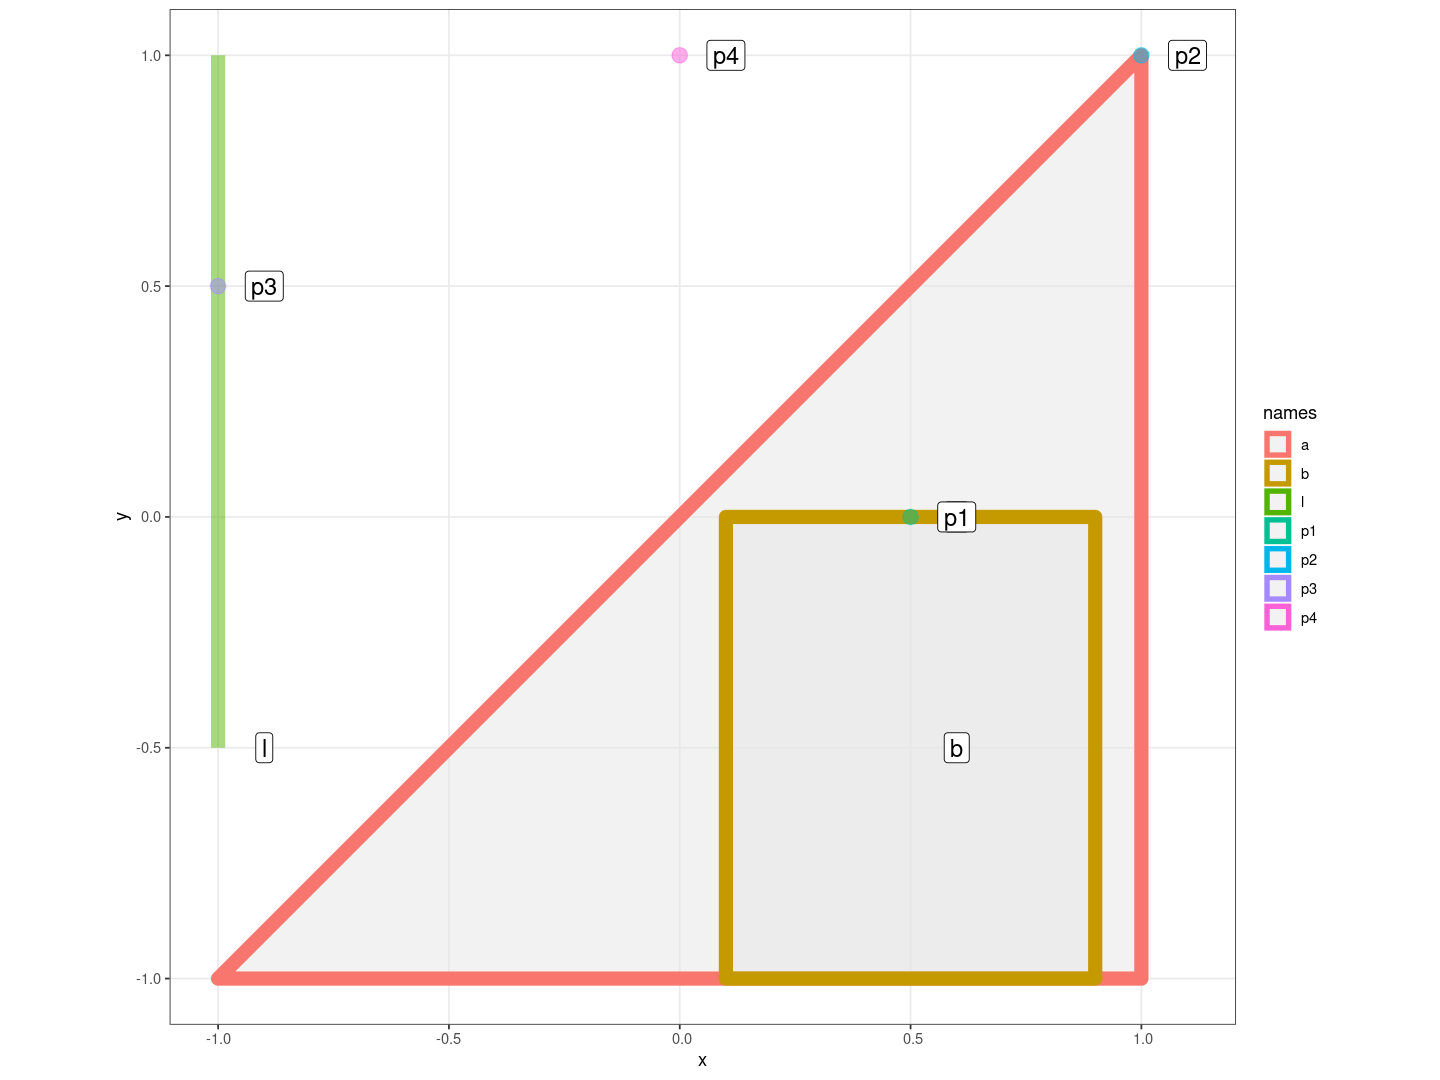

In [4]:
exampleGeometries %>%
    ggplot() +
    theme_bw() +
    geom_sf(aes(col=names), alpha=0.5, size=4) +
    geom_sf_label(aes(label=names), size=5, nudge_x=.1)  


Which points intersect with the large polygon?

In [5]:
st_intersects(p, a, sparse=F)

TRUE
TRUE
FALSE
FALSE


Note that the result for `p2` is `TRUE`, even though the point is at the boundary of the polygon.

The two polygons of course also intersect.

In [6]:
st_intersects(b, a, sparse=F)

TRUE


The opposite of `sp_intersects` is `sp_disjoint`.

In [7]:
st_disjoint(p, a, sparse = F)


FALSE
FALSE
TRUE
TRUE


`st_within` returns `TRUE` only in case of complete inclusion. 

In [8]:
st_within(p, a, sparse=F)


TRUE
FALSE
FALSE
FALSE


In [9]:
st_within(p, b, sparse=F)


FALSE
FALSE
FALSE
FALSE


`st_touches` is true if a point or line or border of a polygon includes the other object.

In [10]:
st_touches(p, a, sparse=F)


FALSE
TRUE
FALSE
FALSE


`st_is_within_distance` does what its name says. (NB: This is not a topological relation.)

In [11]:
0.75 * sqrt(2)

[1] 1.06066

In [12]:
st_is_within_distance(p, a, dist = 0.9, sparse=F)


TRUE
TRUE
FALSE
TRUE


## Geometric operations on vector data

Geometric operations create geometric objects out of geometric objects. They include

- simplification
- finding centroids of areas
- creating buffers around geometries
- affine transformations (shifting, scaling, rotating)
- clipping
- geometric union
- Voronoi tesselation

### Geometric simplification

Linestrings and polygons may consists of many segments, not all of which are needed for a specific purpose.

Consider this representation of the river Seine with tributuaries from `spData`:

In [13]:
seine

name,geometry
<chr>,<MULTILINESTRING [m]>
Marne,MULTILINESTRING ((879955.3 ...
Seine,MULTILINESTRING ((828893.6 ...
Yonne,MULTILINESTRING ((773482.1 ...


In [14]:
seine %>%
    st_geometry() %>%
    st_cast("POINT")

POINT (879955.3 6755725)

POINT (878440.9 6755688)

POINT (876653.8 6756227)

POINT (874212.2 6757918)

POINT (873572.2 6758374)



Geometry set for 658 features 
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 518344.7 ymin: 6660431 xmax: 879955.3 ymax: 6938864
Projected CRS: RGF93 / Lambert-93
First 5 geometries:

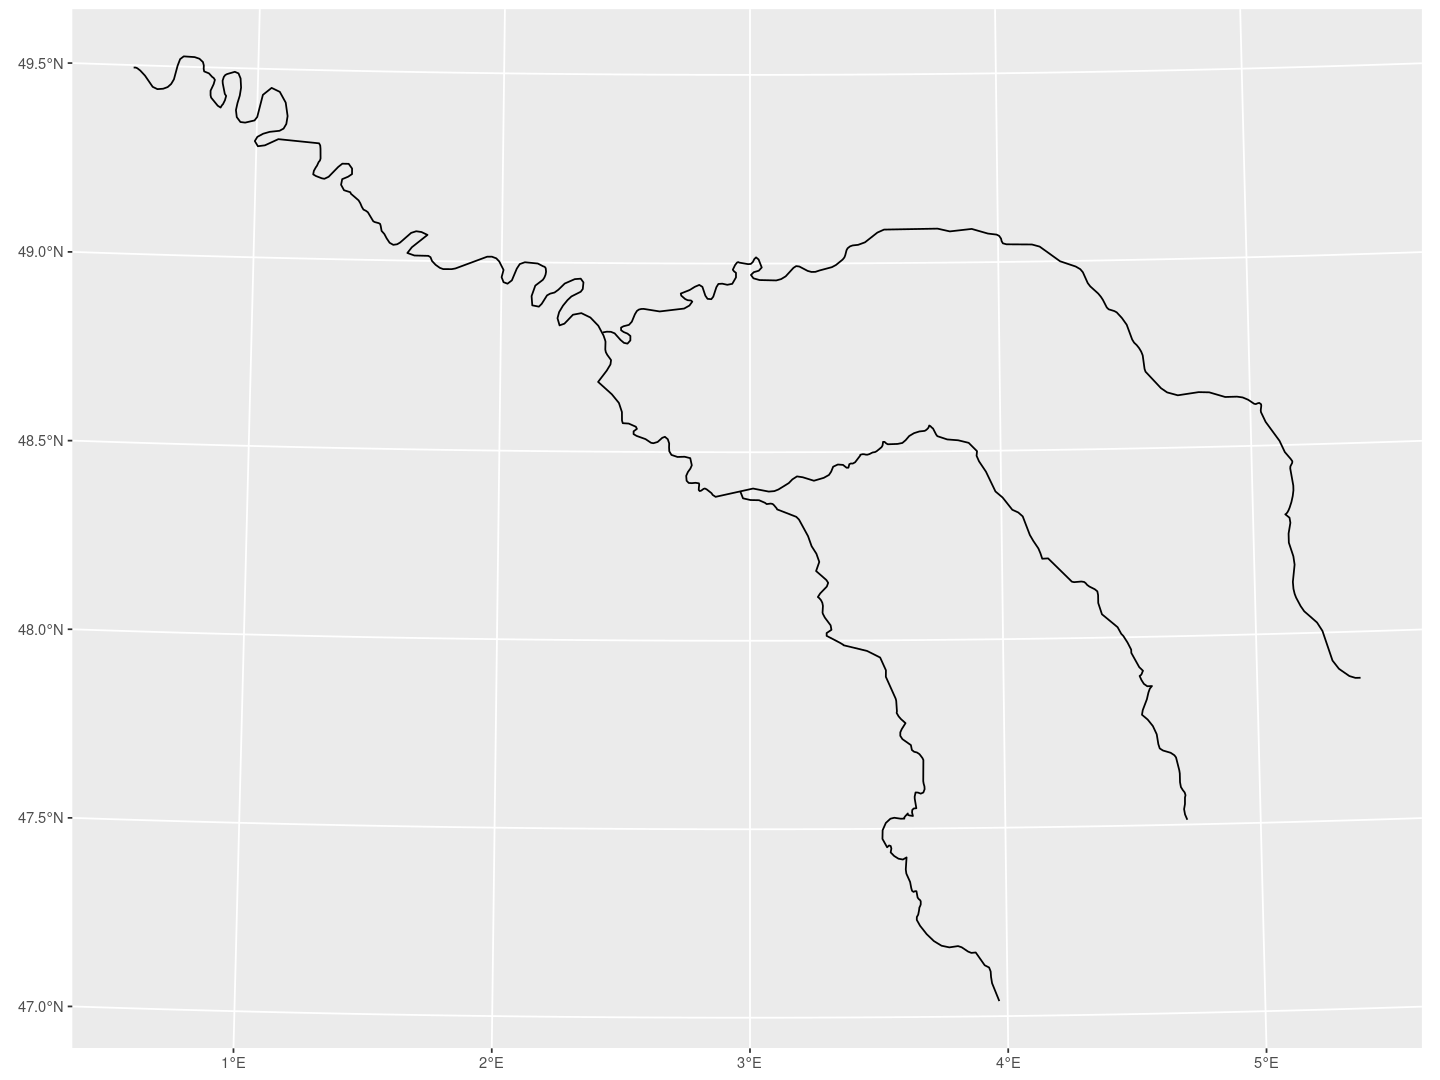

In [15]:
seine %>%
    ggplot() +
    geom_sf()

With `st_simplify` we can remove points while preserving the overall shape. The `dTolarance` argument determines how strongly the shape is simplified.

In [16]:
dt = 2000 # units are metre
seine %>%
    st_simplify(dTolerance=dt) %>%
    st_geometry() %>%
    st_cast("POINT") %>%
    length()

[1] 108

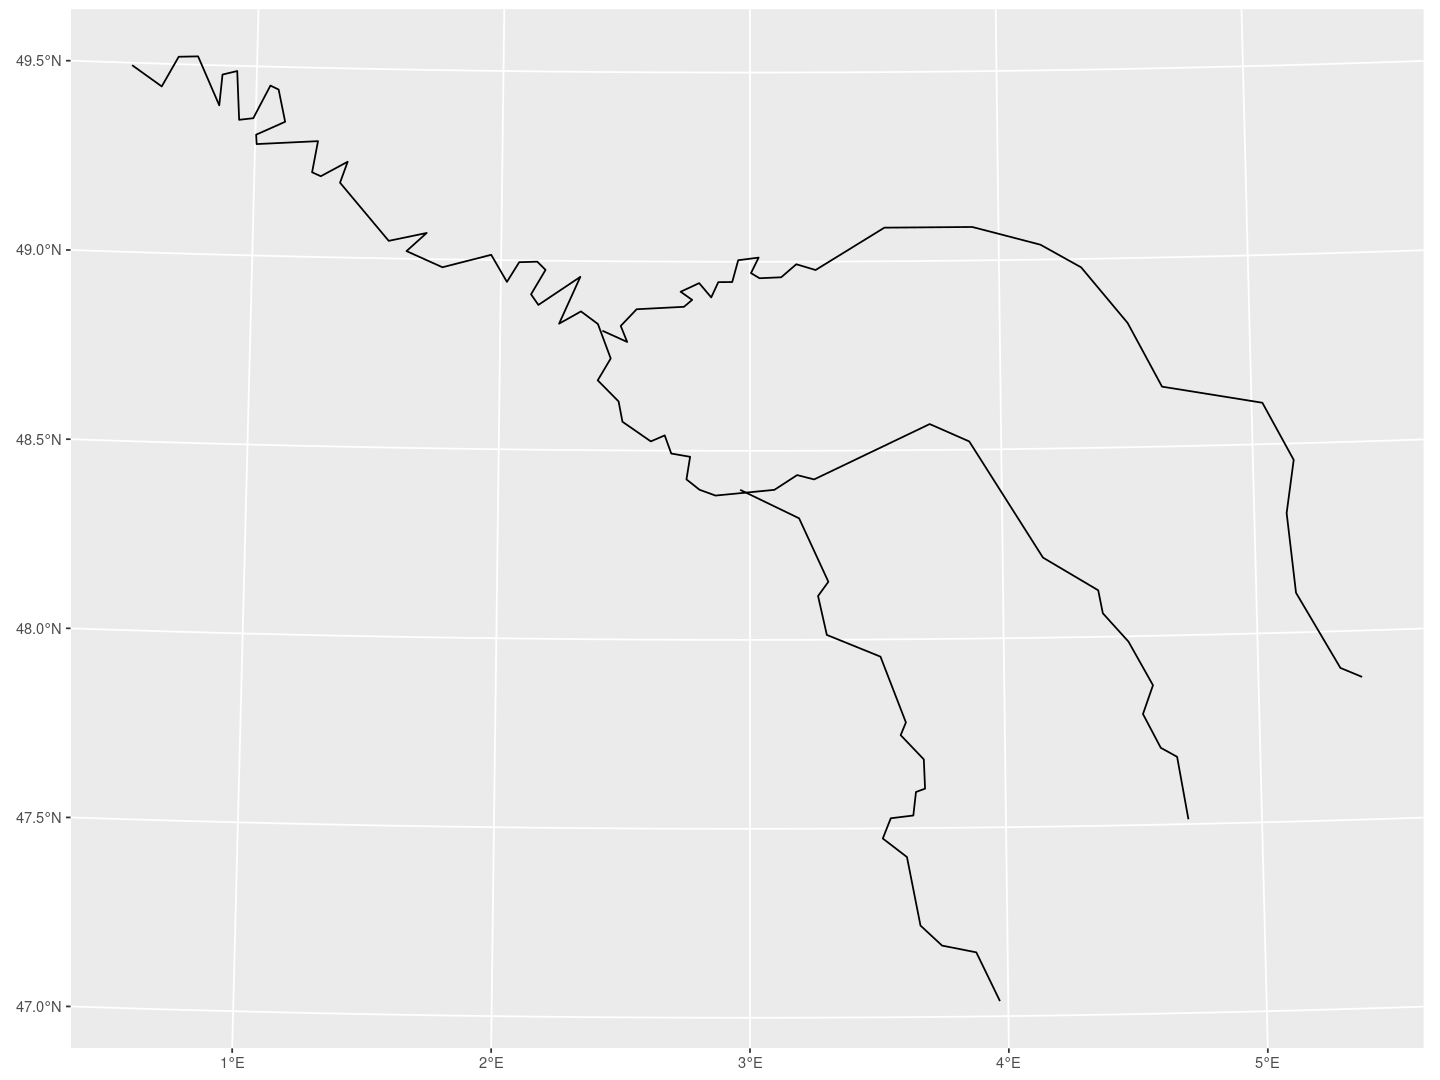

In [17]:
seine %>%
    st_simplify(dTolerance=dt) %>%
    ggplot() +
    geom_sf()

### Simplification of polygons

`st_simplify` also applies to polygons. There is a catch though.



In [18]:
us_states_wu <- us_states %>%
    mutate(AREA = as.numeric(AREA)) 

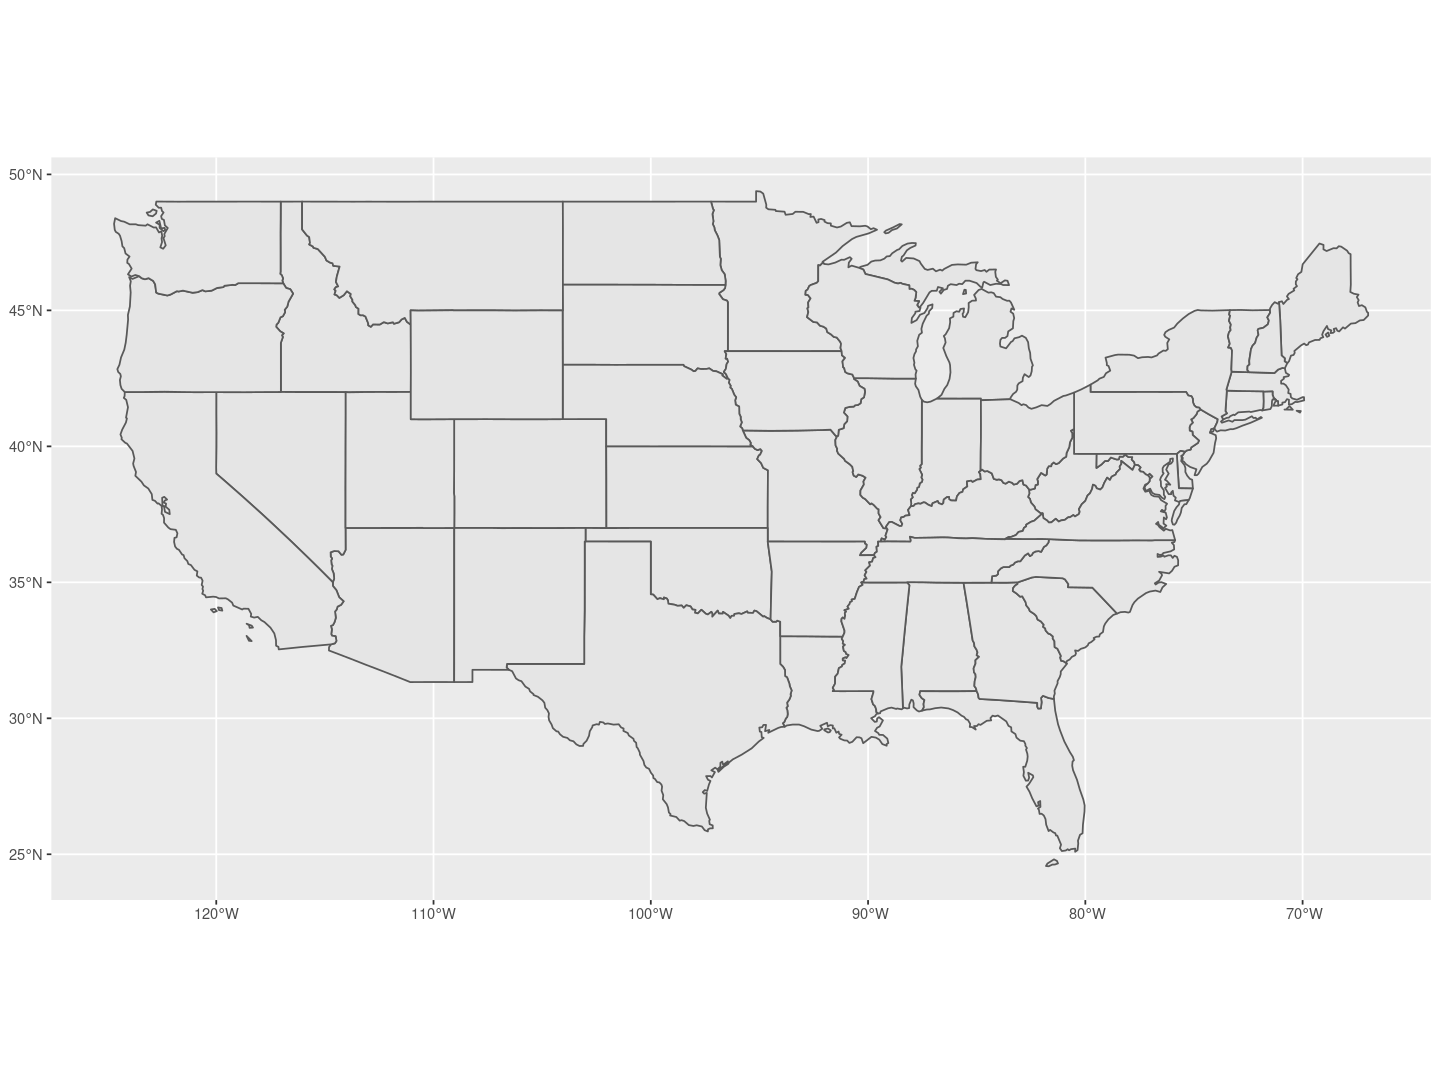

In [19]:
us_states_wu %>%
    ggplot() +
    geom_sf()

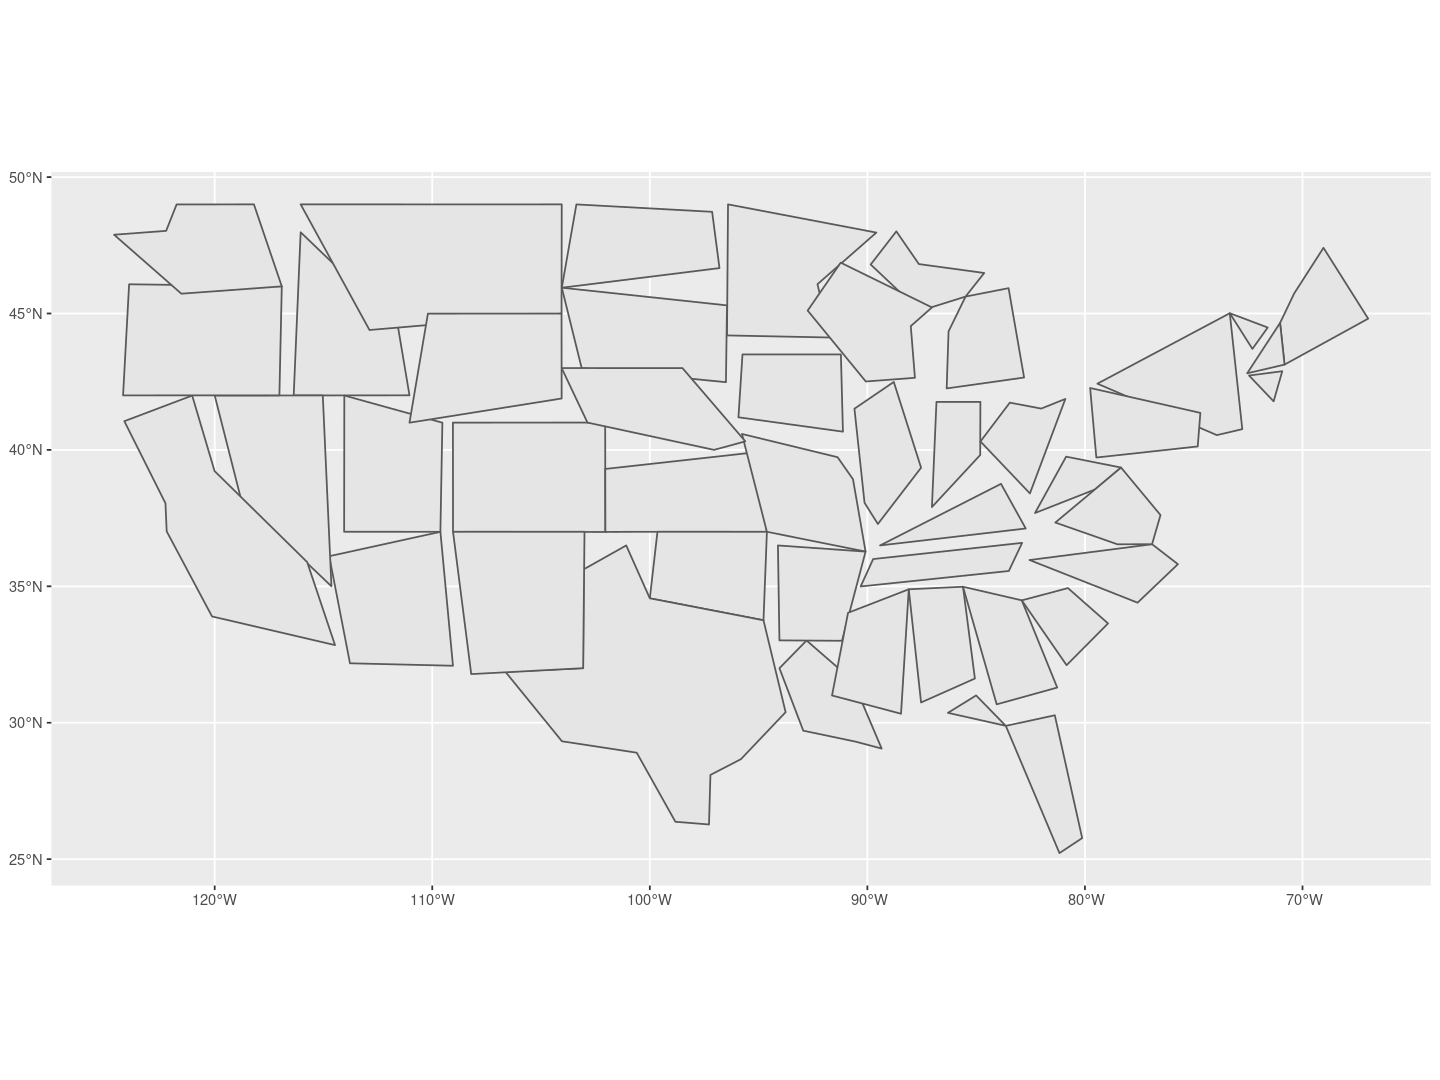

In [20]:

us_states_wu %>%
    st_simplify(dTolerance=100000) %>%
    ggplot() +
    geom_sf()

`st_simplify` simplifies each geometry individually, without regard of shared borders. 

An alternative is the function `ms_simplify` from the package `rmapshaper`.

In [21]:
install.packages("rmapshaper")

Installing package into ‘/home/gjaeger/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)



Registered S3 method overwritten by 'geojsonlint':
  method         from 
  print.location dplyr



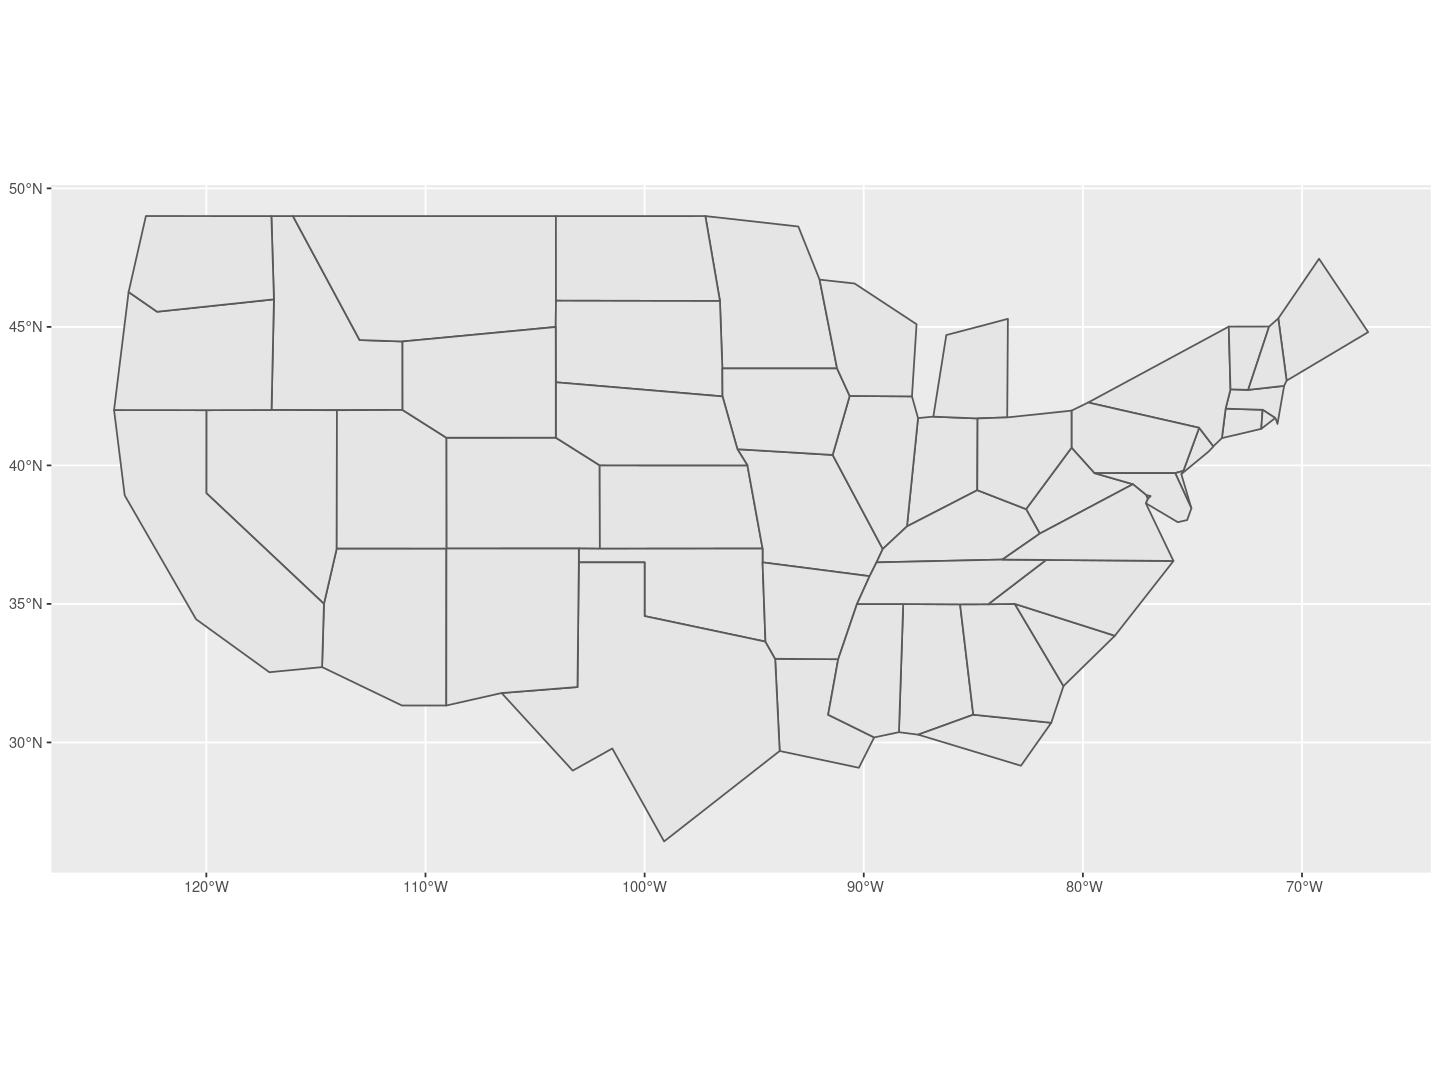

In [22]:
library(rmapshaper)
us_states_wu %>%
    ms_simplify(keep=0.01, keep_shapes=T) %>%
    ggplot() +
    geom_sf()


## Centroids

The *centroid* of an area is its middle point. There are multiple ways to define what "middle" means hear. In the simplest case, it is just the center of gravity.

`st_centroid` computes the centroids of geometries.

Warning message in st_point_on_surface.sf(.):
“st_point_on_surface assumes attributes are constant over geometries of x”
Warning message in st_point_on_surface.sfc(st_geometry(x)):
“st_point_on_surface may not give correct results for longitude/latitude data”


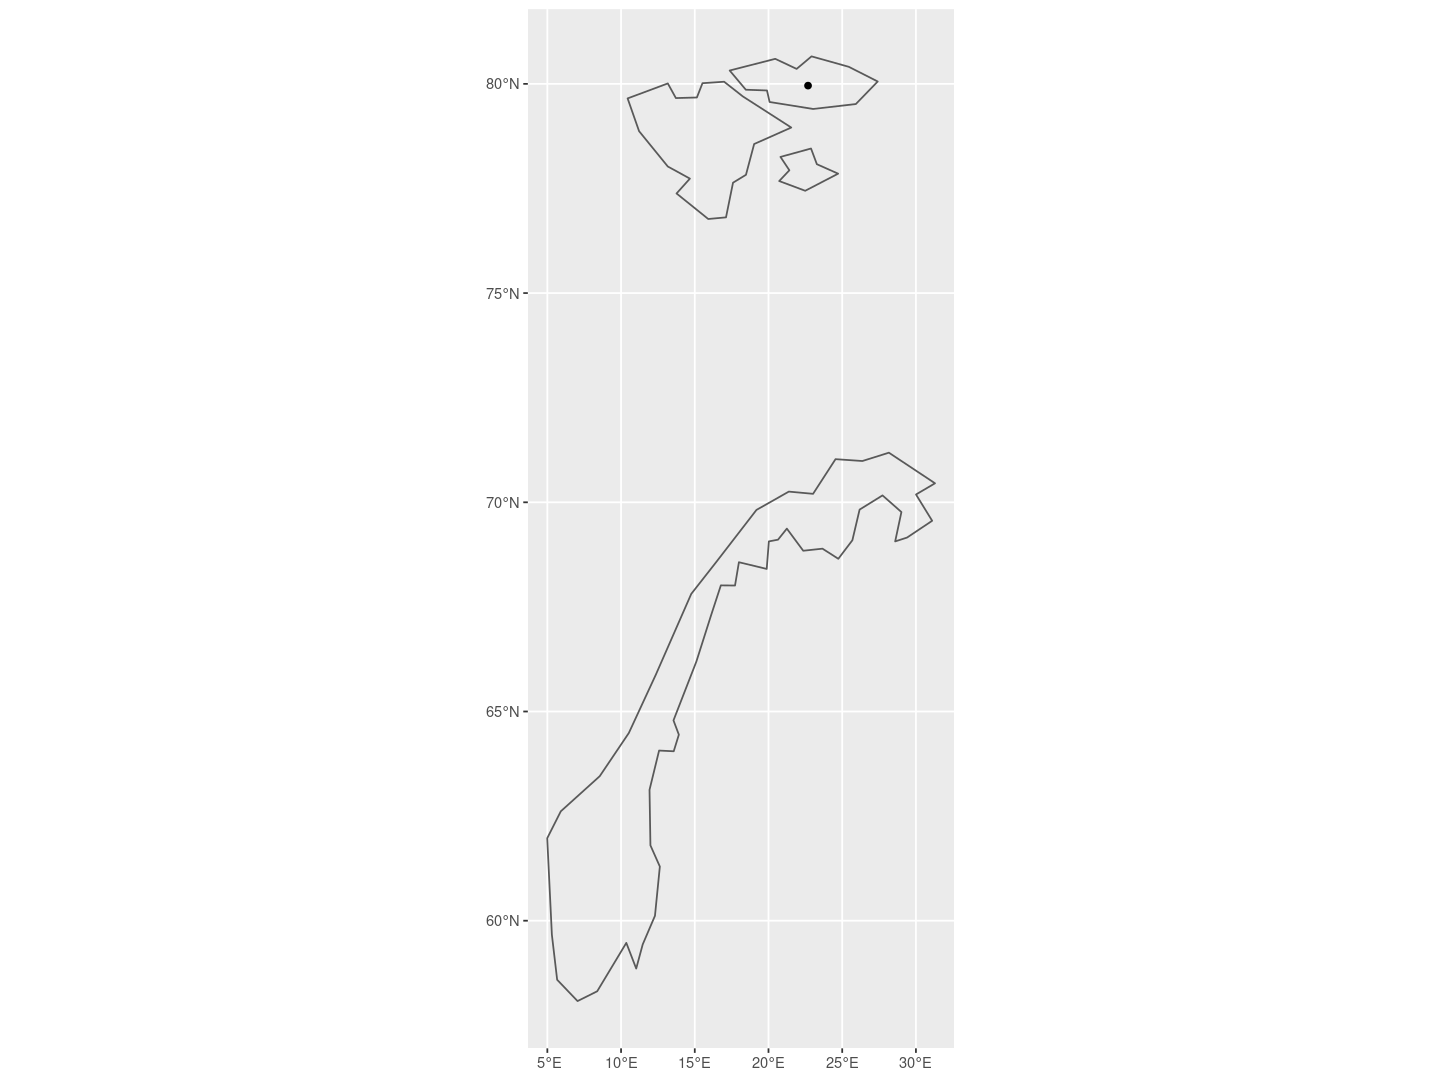

In [23]:
world %>%
    filter(name_long == "Norway") %>%
    st_point_on_surface() %>%
    ggplot() +
    geom_sf() +
    geom_sf(data=filter(world, name_long == "Norway"), alpha=0)

The operation can also be applied to linestrings.

Warning message in st_centroid.sf(.):
“st_centroid assumes attributes are constant over geometries of x”


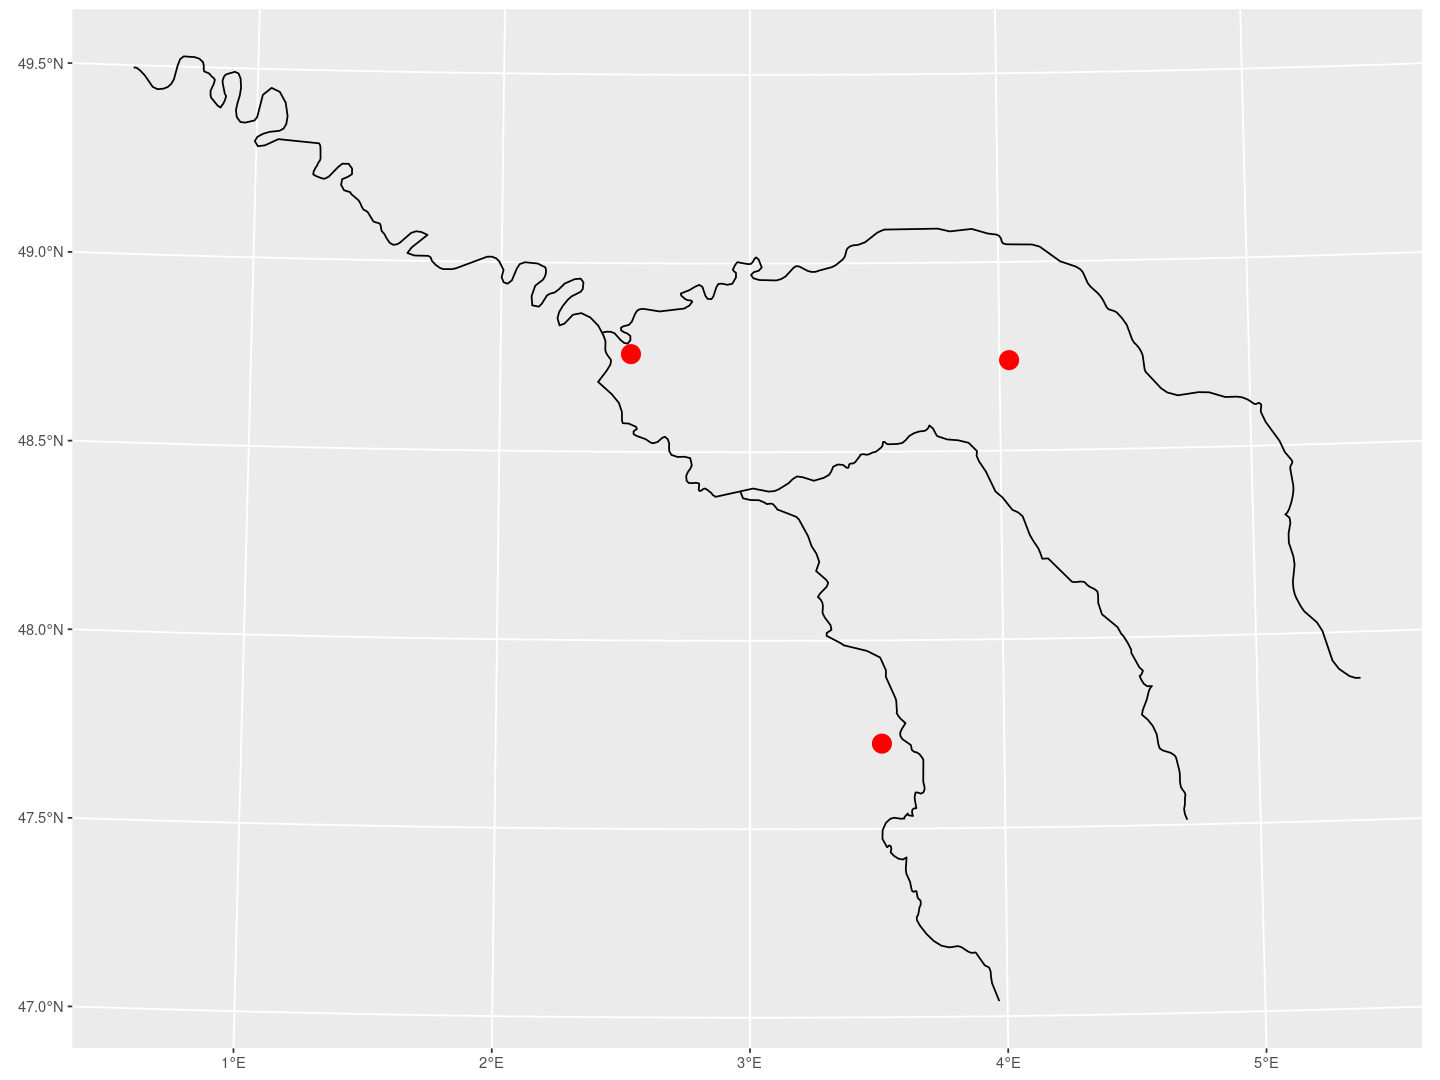

In [24]:
seine %>%
    st_centroid() %>%
    ggplot() +
    geom_sf(col="red", size=5) +
    geom_sf(data=seine)

Here you see that the centroid of an object need not be included in it. We can enforce this with `st_point_on_surface`. 

This is also useful for multipolygons with several components, or concavely shaped polygons.

Warning message in st_point_on_surface.sf(.):
“st_point_on_surface assumes attributes are constant over geometries of x”


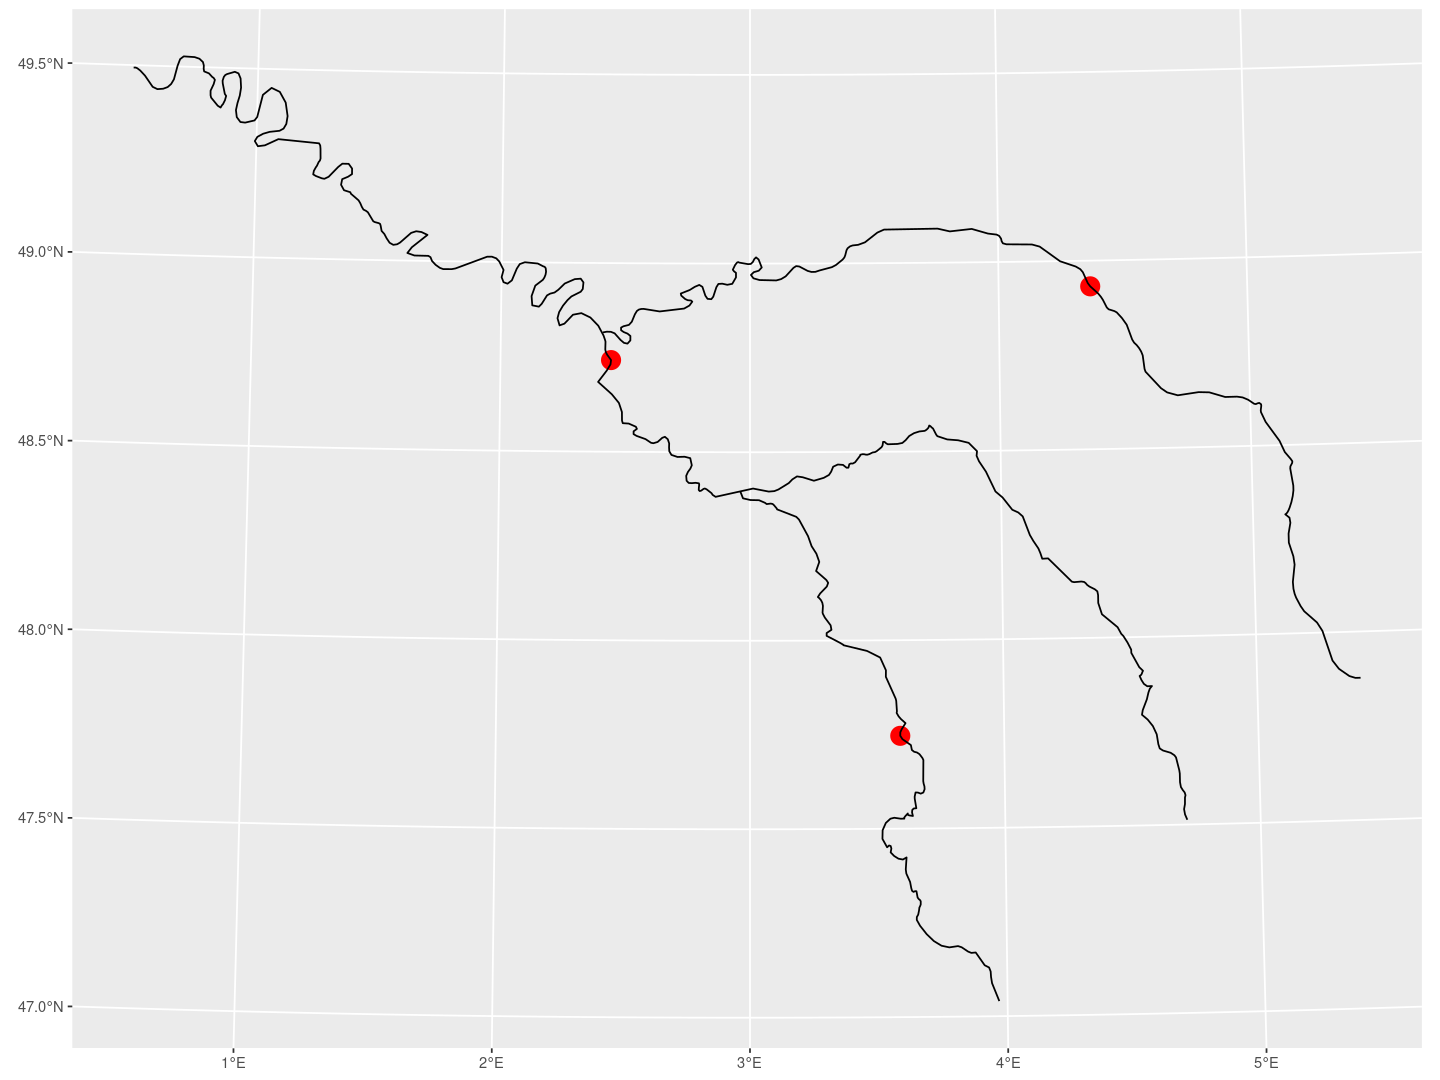

In [25]:
seine %>%
    st_point_on_surface() %>%
    ggplot() +
    geom_sf(col="red", size=5) +
    geom_sf(data=seine)

## Buffers

A spatial *buffer* around a geometry is the area of points within a certain distance of this geometry. It is always a (multi)polygon.

In [26]:
seine

name,geometry
<chr>,<MULTILINESTRING [m]>
Marne,MULTILINESTRING ((879955.3 ...
Seine,MULTILINESTRING ((828893.6 ...
Yonne,MULTILINESTRING ((773482.1 ...


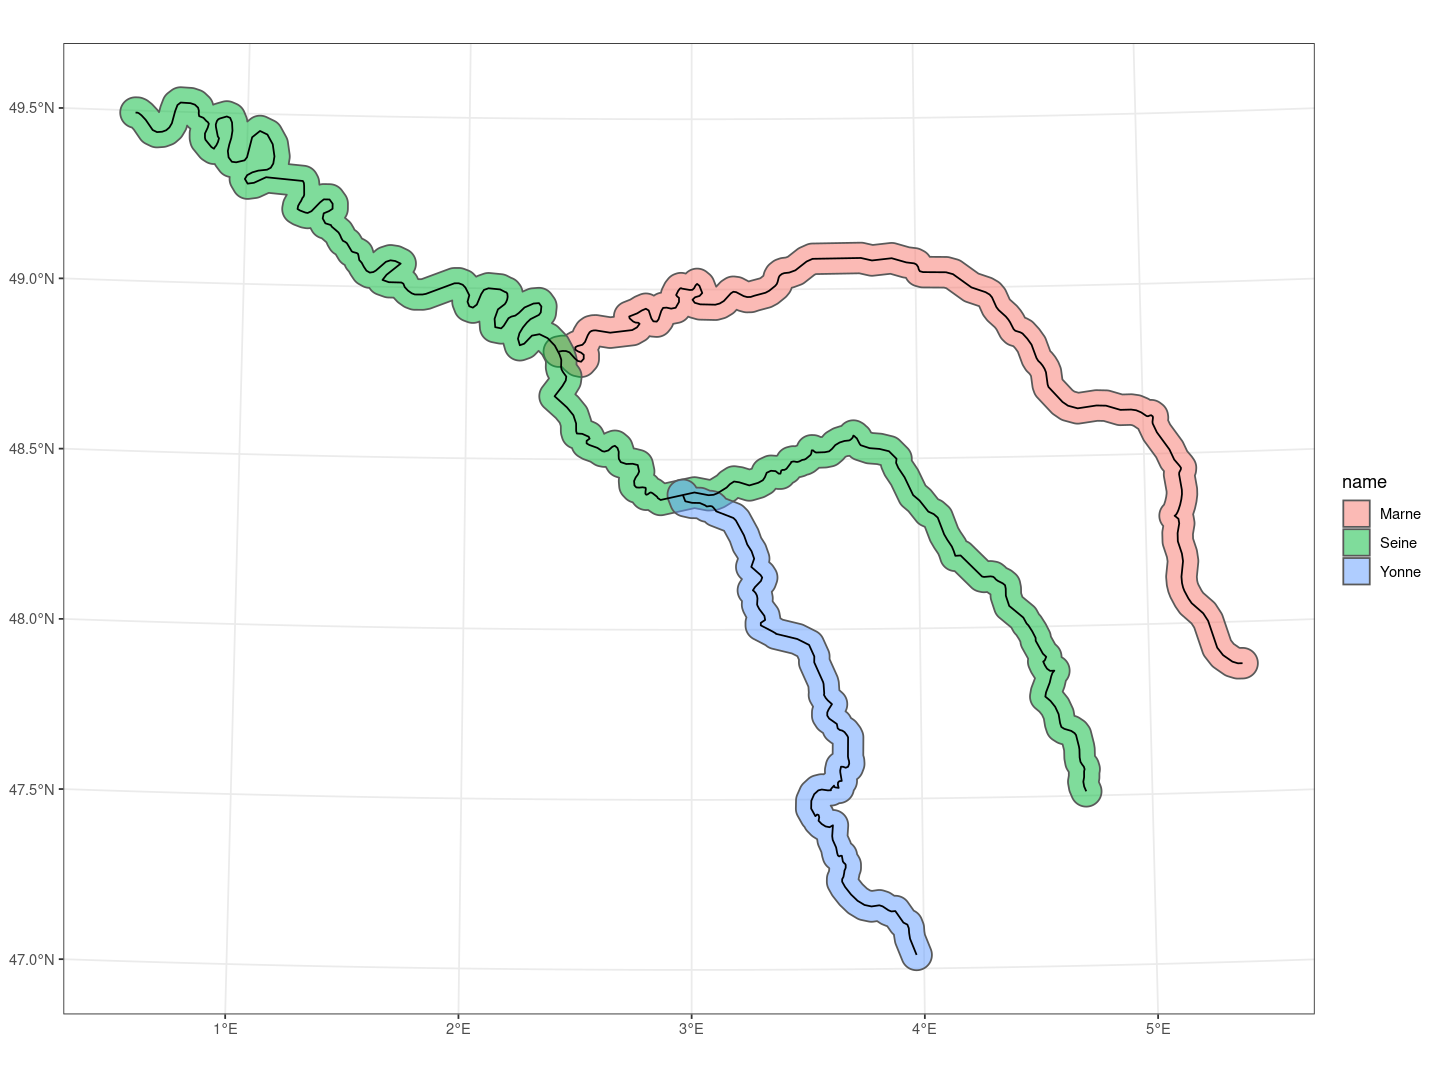

In [27]:
seine %>%
    st_buffer(dist = 5000) %>%
    ggplot() +
    theme_bw() +
    geom_sf(aes(fill=name), alpha=0.5) +
    geom_sf(data=seine)

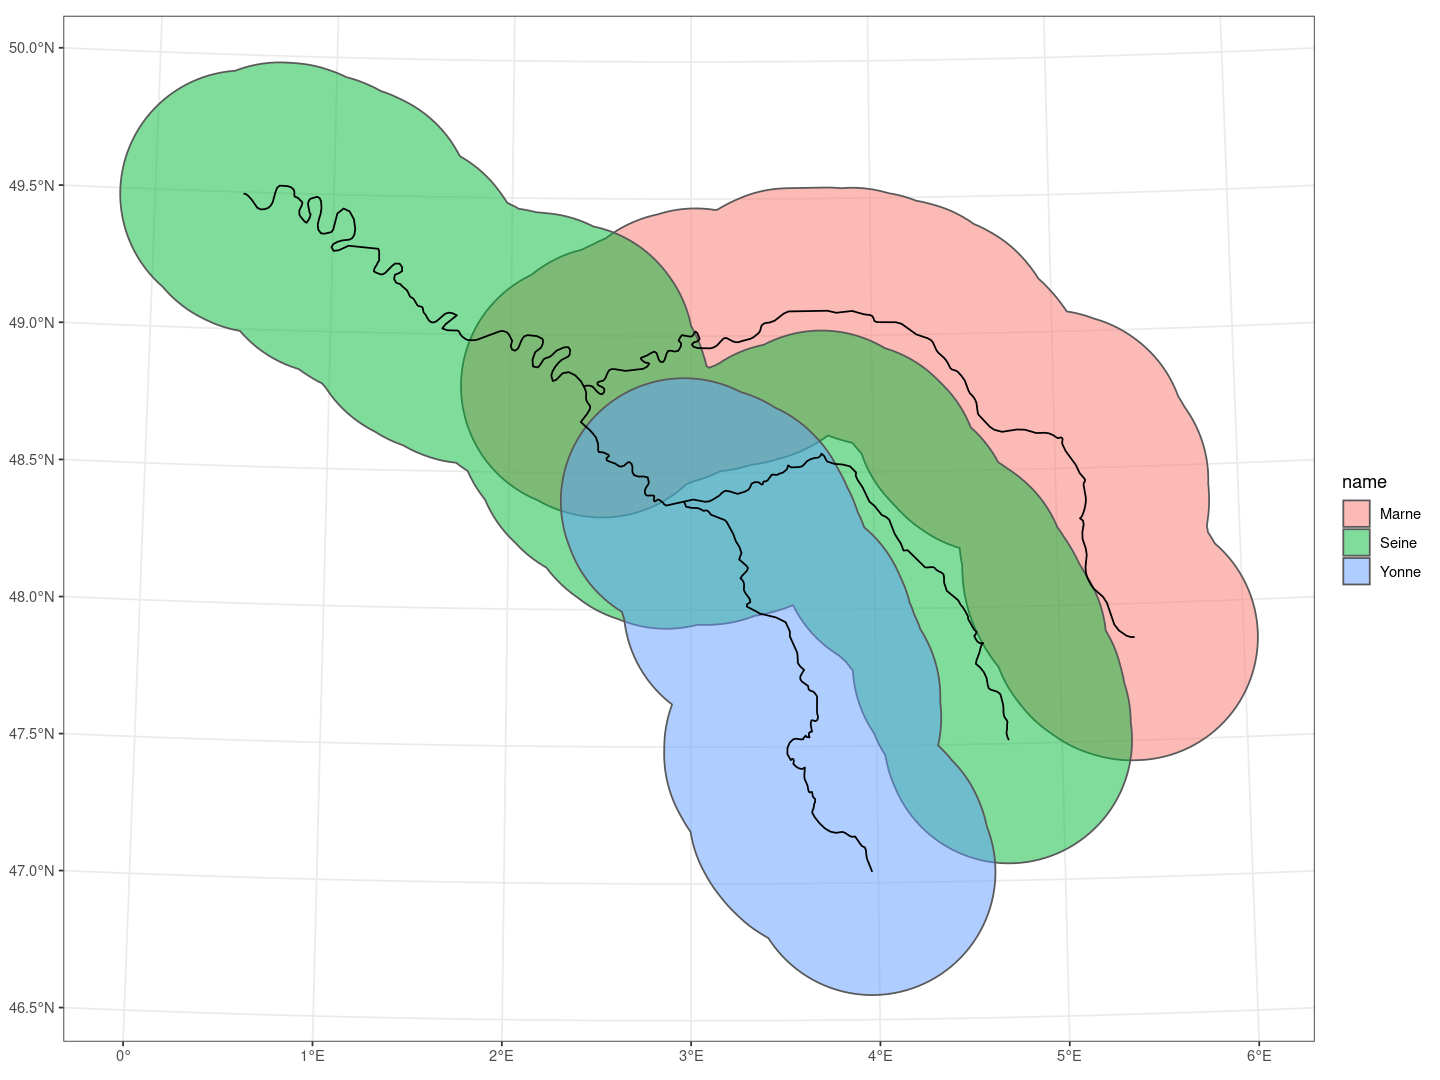

In [28]:
seine %>%
    st_buffer(dist = 50000) %>%
    ggplot() +
    theme_bw() +
    geom_sf(aes(fill=name), alpha=0.5) +
    geom_sf(data=seine)

## Affine transformations

These are all geometric transformations that preserve straight lines and parallels. They are applicable to geometries and geometry columns. The implementation in `sf` is so that we can apply the same operations we would apply to vectors.


### Translation

Simply add the translation vector to the geometries.

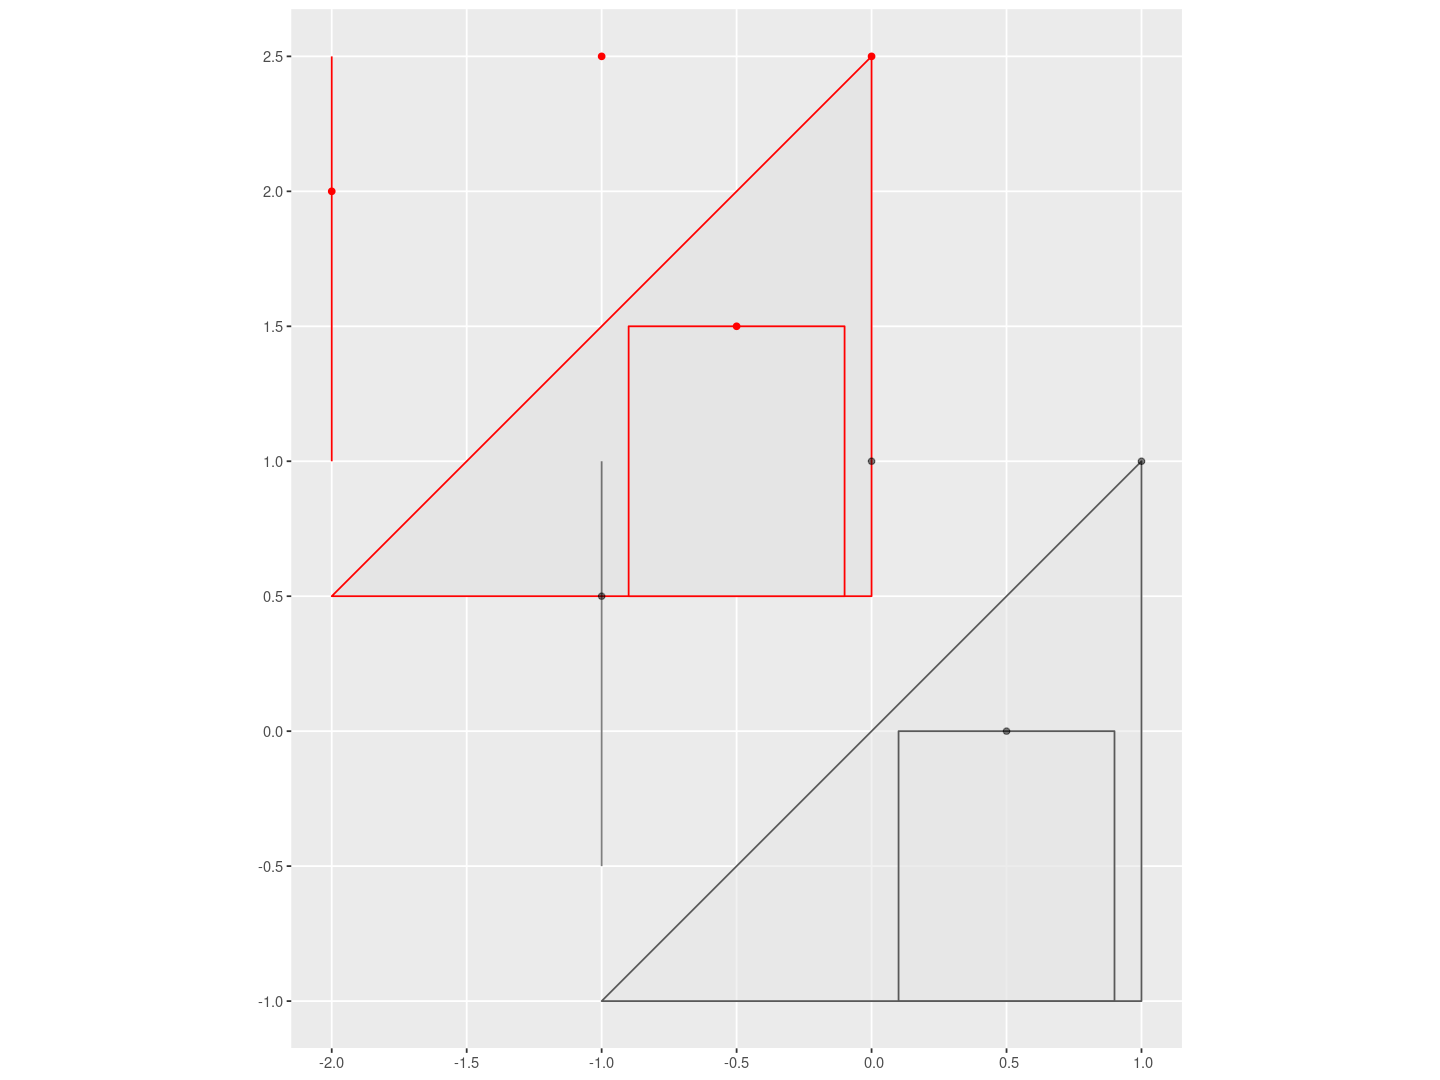

In [29]:
(exampleGeometries %>%
    st_geometry() + c(-1, 1.5)) %>% 
    ggplot() +
    geom_sf(col='red') +
    geom_sf(data=exampleGeometries, alpha=0.5)



### Mirroring

Multiply the geometries with the matrix
$$
\begin{pmatrix}
-1 & 0\\
0 & 1
\end{pmatrix}
$$

for mirroring along the $x$-axis, and 

$$
\begin{pmatrix}
1 & 0\\
0 & -1
\end{pmatrix}
$$

along the $y$-axis.


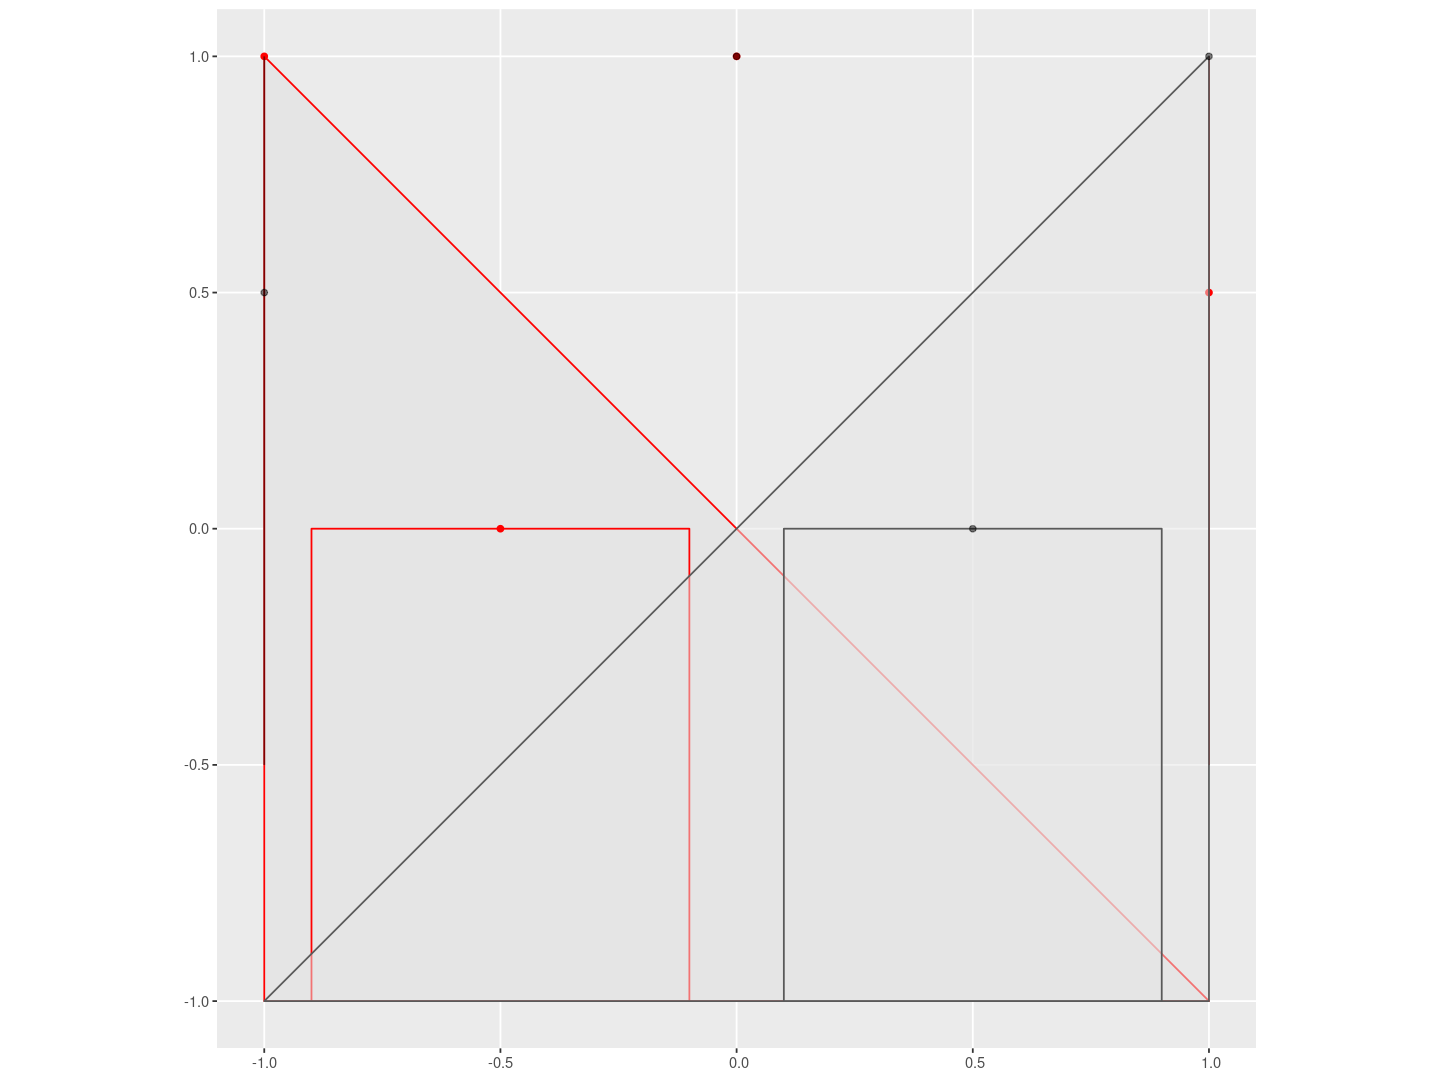

In [30]:

(exampleGeometries %>%
    st_geometry() * matrix(c(-1, 0, 0, 1), nrow=2)) %>%
    ggplot() +
    geom_sf(col='red') +
    geom_sf(data=exampleGeometries, alpha=0.5)

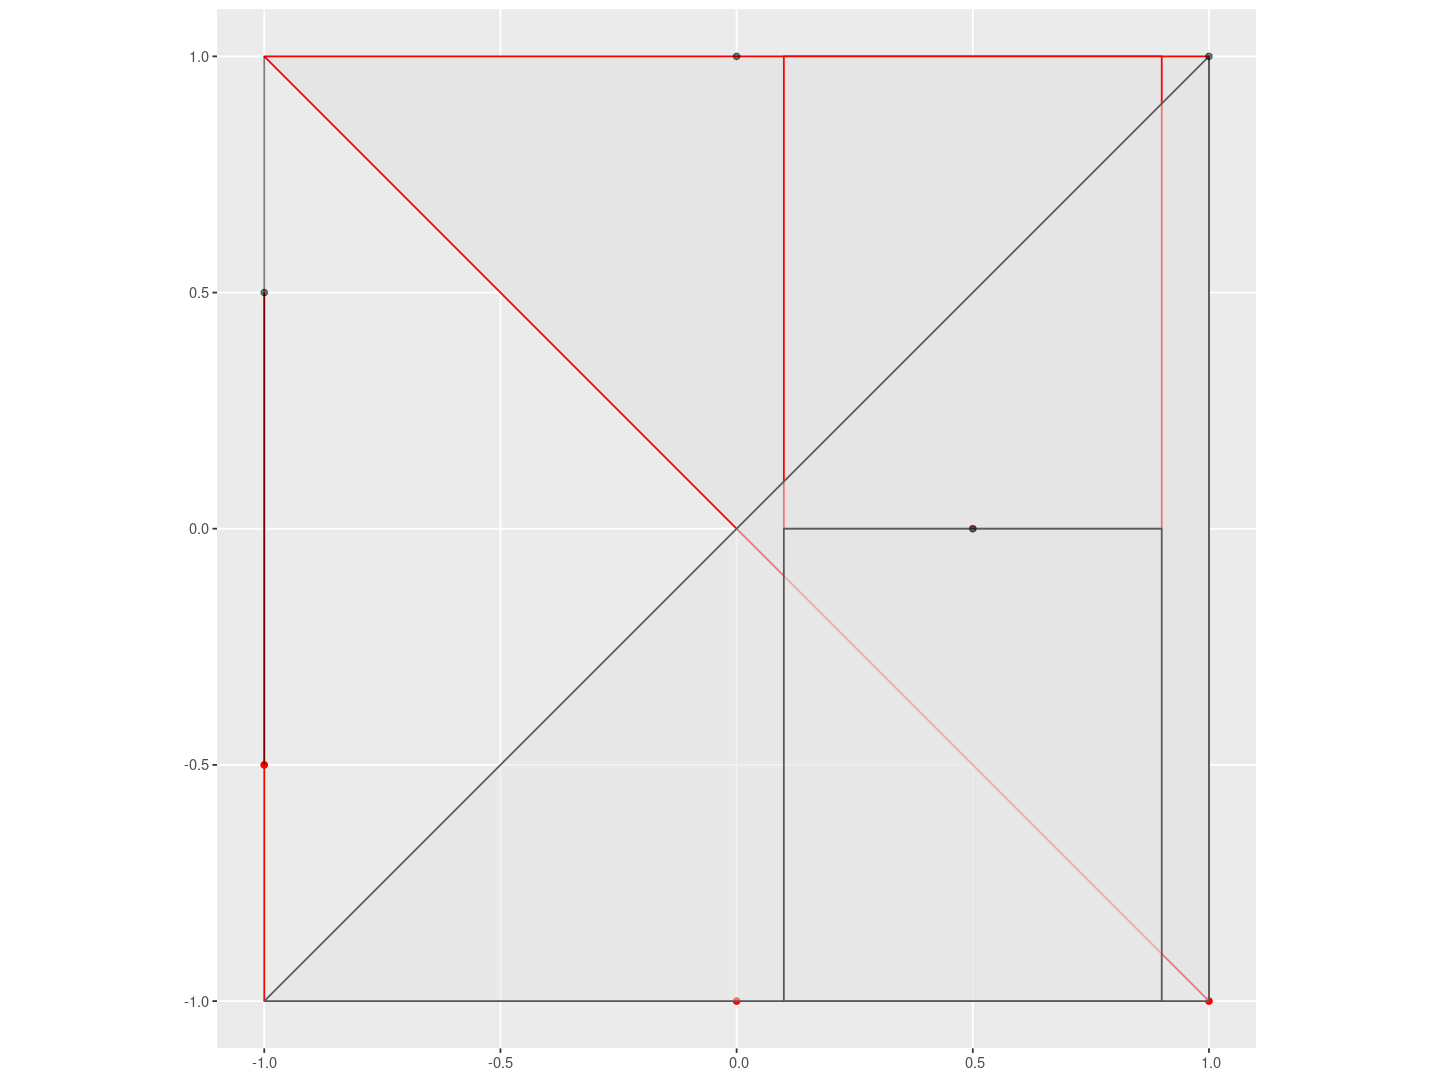

In [31]:
(exampleGeometries %>%
    st_geometry() * matrix(c(1, 0, 0, -1), nrow=2)) %>%
    ggplot() +
    geom_sf(col='red') +
    geom_sf(data=exampleGeometries, alpha=0.5)

### Skewing

Multiply the geometries with the matrix 
$$
\begin{pmatrix}
u \\v
\end{pmatrix}
$$

where $u$ is the image of the vector $\begin{pmatrix}1\\0\end{pmatrix}$, and $v$ the image of $\begin{pmatrix}0\\1\end{pmatrix}$

In [32]:
(skewMatrix <- matrix(
    c(1, 1, 0, 1), nrow=2
))

1,0
1,1


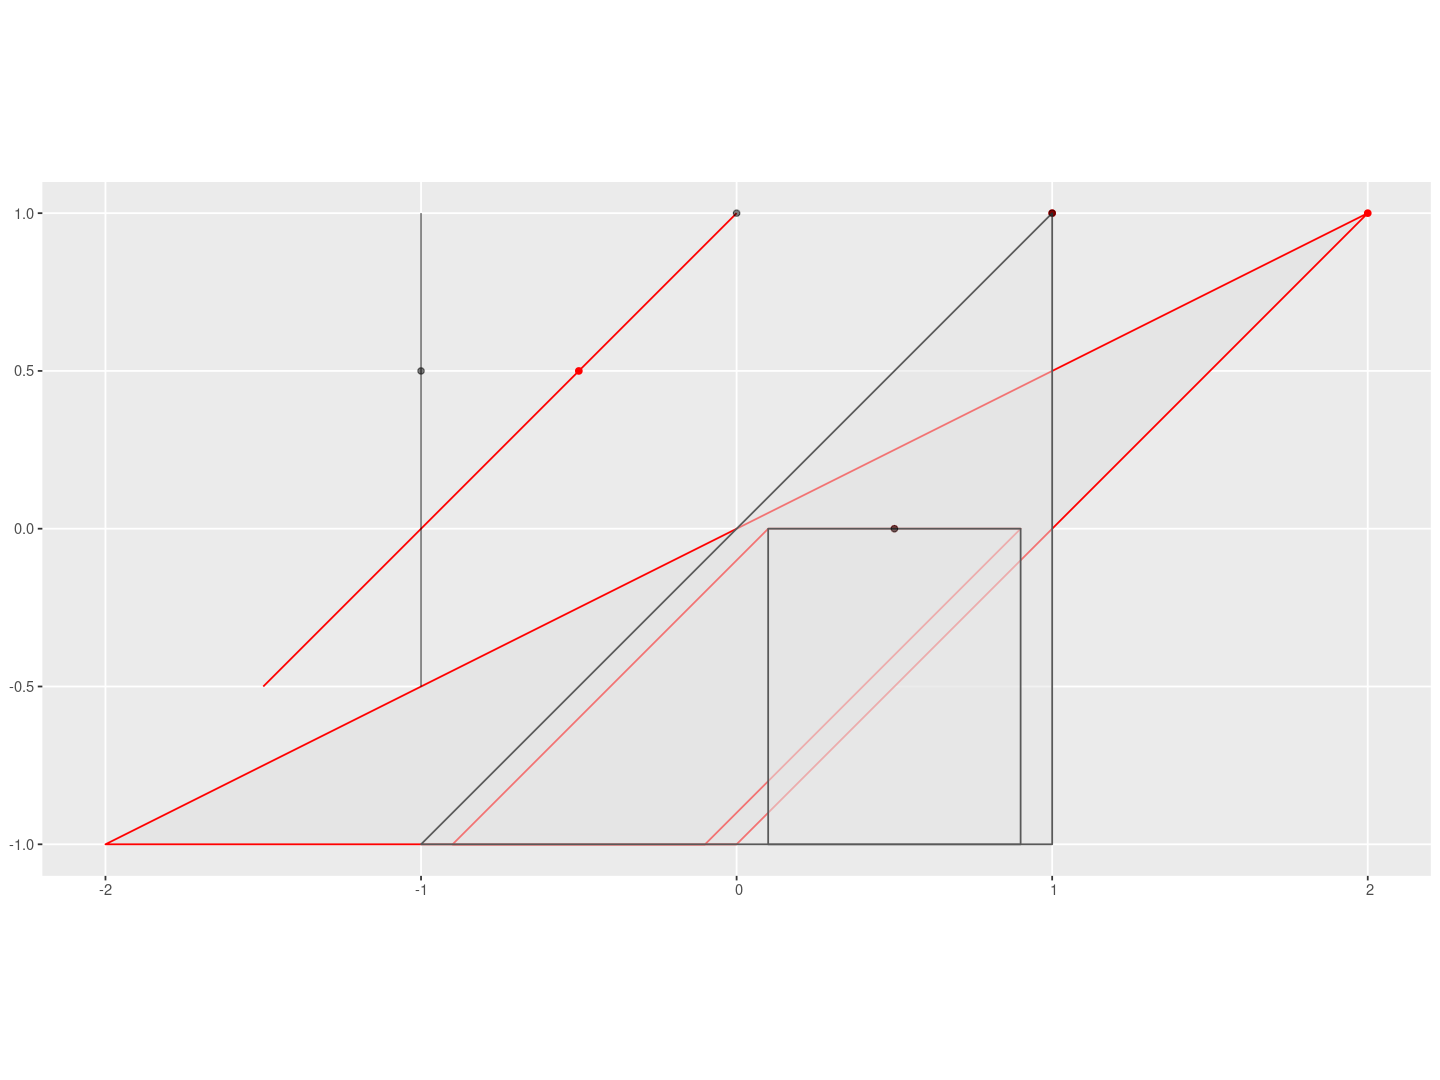

In [33]:
(exampleGeometries %>%
    st_geometry() * skewMatrix)  %>%
    ggplot() +
    geom_sf(col='red') +
    geom_sf(data=exampleGeometries, alpha=0.5)

### Rotation

works as skewing, via matrix multiplication.

#### Matrix for clock-wise rotation by 45°:

In [34]:
(rotationMatrix <- matrix(
    c(sqrt(.5), sqrt(.5), -sqrt(.5), sqrt(.5)),
    nrow=2
))

0.7071068,-0.7071068
0.7071068,0.7071068


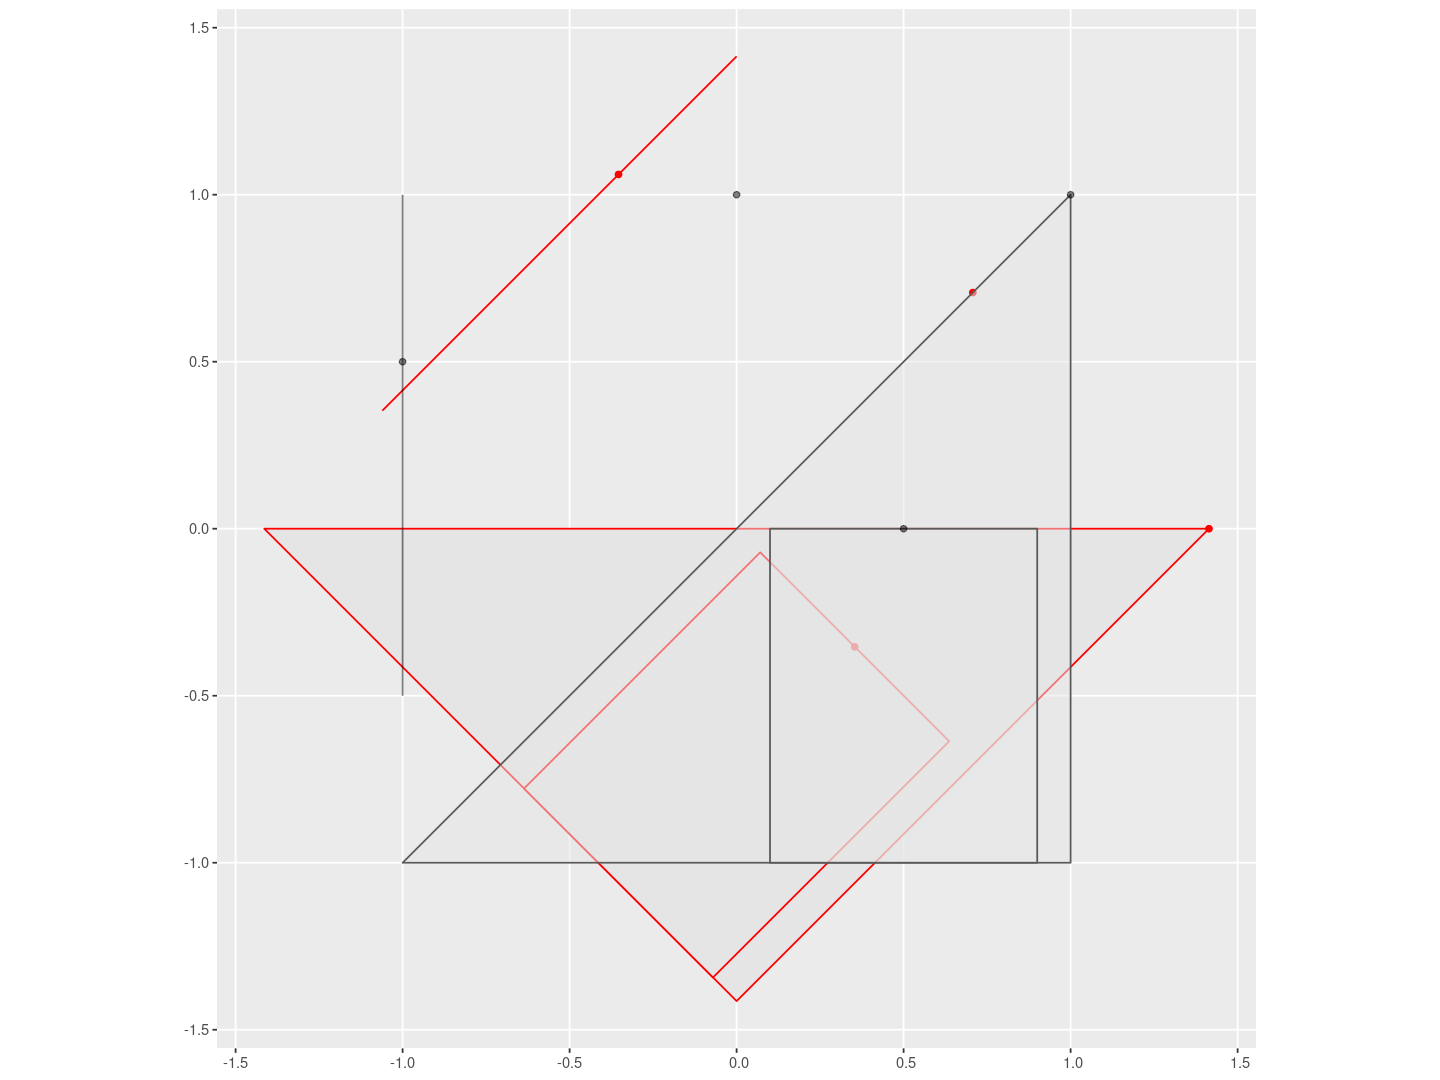

In [35]:
(exampleGeometries %>%
    st_geometry() * rotationMatrix)  %>%
    ggplot() +
    geom_sf(col='red') +
    geom_sf(data=exampleGeometries, alpha=0.5)

### Scaling

works by the same principle. In a scaling matrix, only the diagonal entries are non-zero. The upper left corner contains the horizontal scale factor, and the lower right corner contains the vertical scale factor.

In [36]:
(scaleMatrix <- matrix(
    c(2, 0, 0, 0.5),
    nrow=2
))

2,0.0
0,0.5


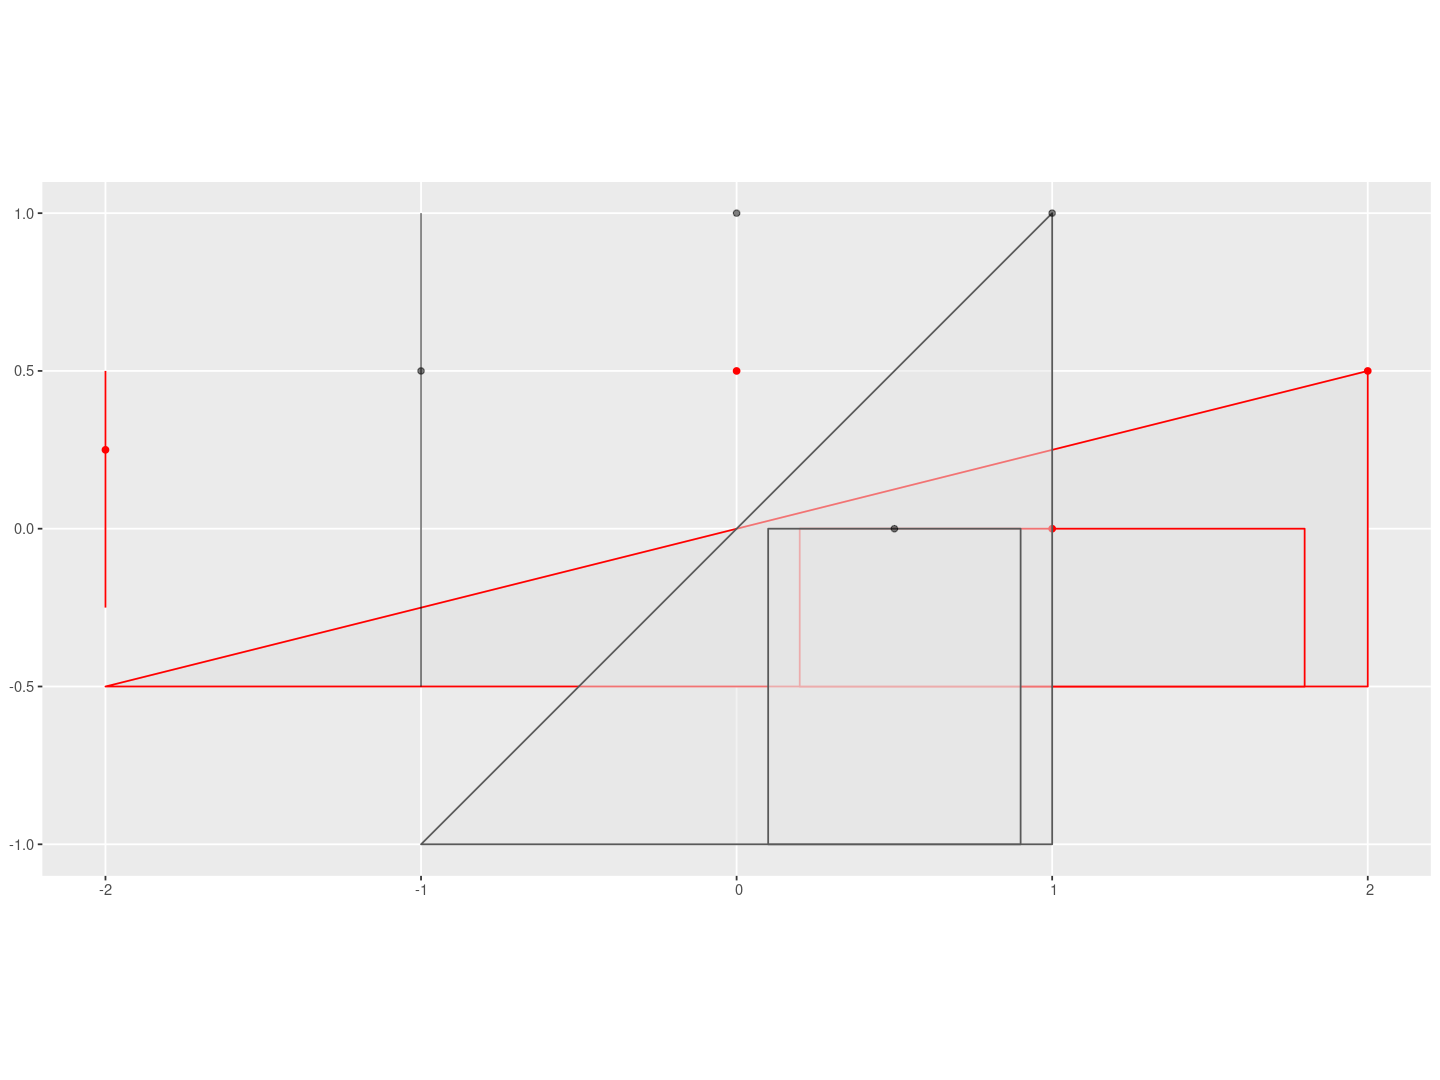

In [37]:
(exampleGeometries %>%
    st_geometry() * scaleMatrix)  %>%
    ggplot() +
    geom_sf(col='red') +
    geom_sf(data=exampleGeometries, alpha=0.5)

## Spatial set-theoretic operations.

We can apply the standard set-theoretic operations to geometries

In [38]:
p1 = st_point(c(-1, 0))
p2 = st_point(c(1, 0))

circles <- st_sfc(p1, p2) %>%
    st_buffer(dist = 1.5) %>%
    st_sf()

circles[["name"]] <- c("A", "B")


In [39]:
circles

,geometry,name
,<POLYGON>,<chr>
1,"POLYGON ((0.5 0, 0.4979443 ...",A
2,"POLYGON ((2.5 0, 2.497944 -...",B


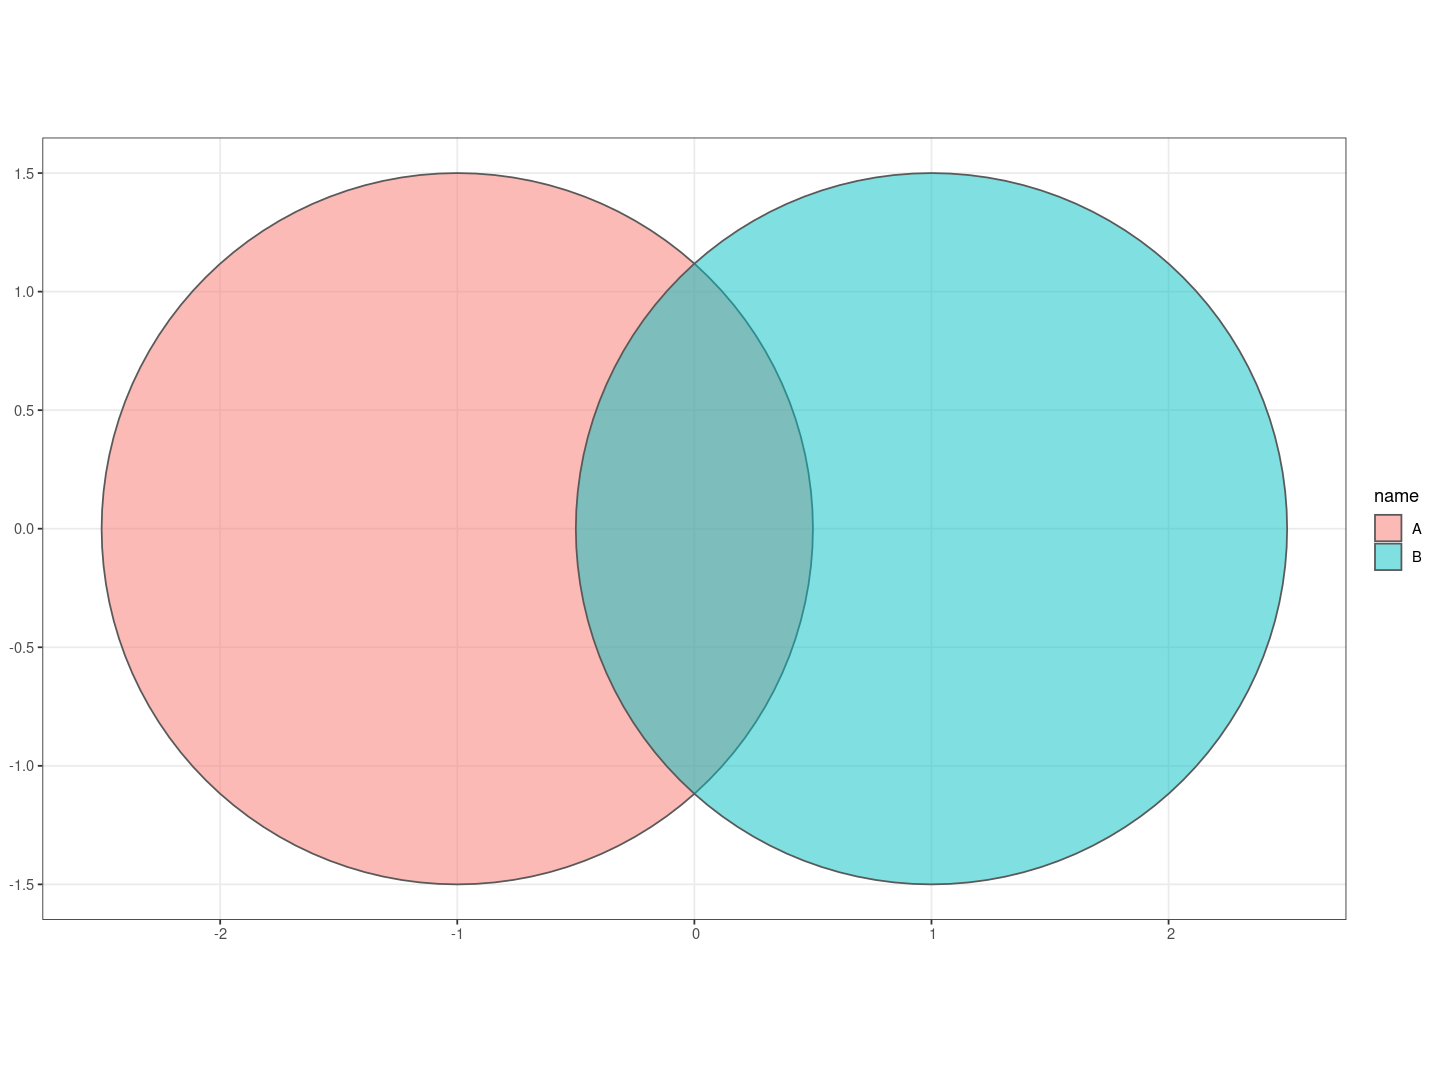

In [40]:
circles %>%
    ggplot() +
    theme_bw() +
    geom_sf(alpha = .5, aes(fill=name))

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


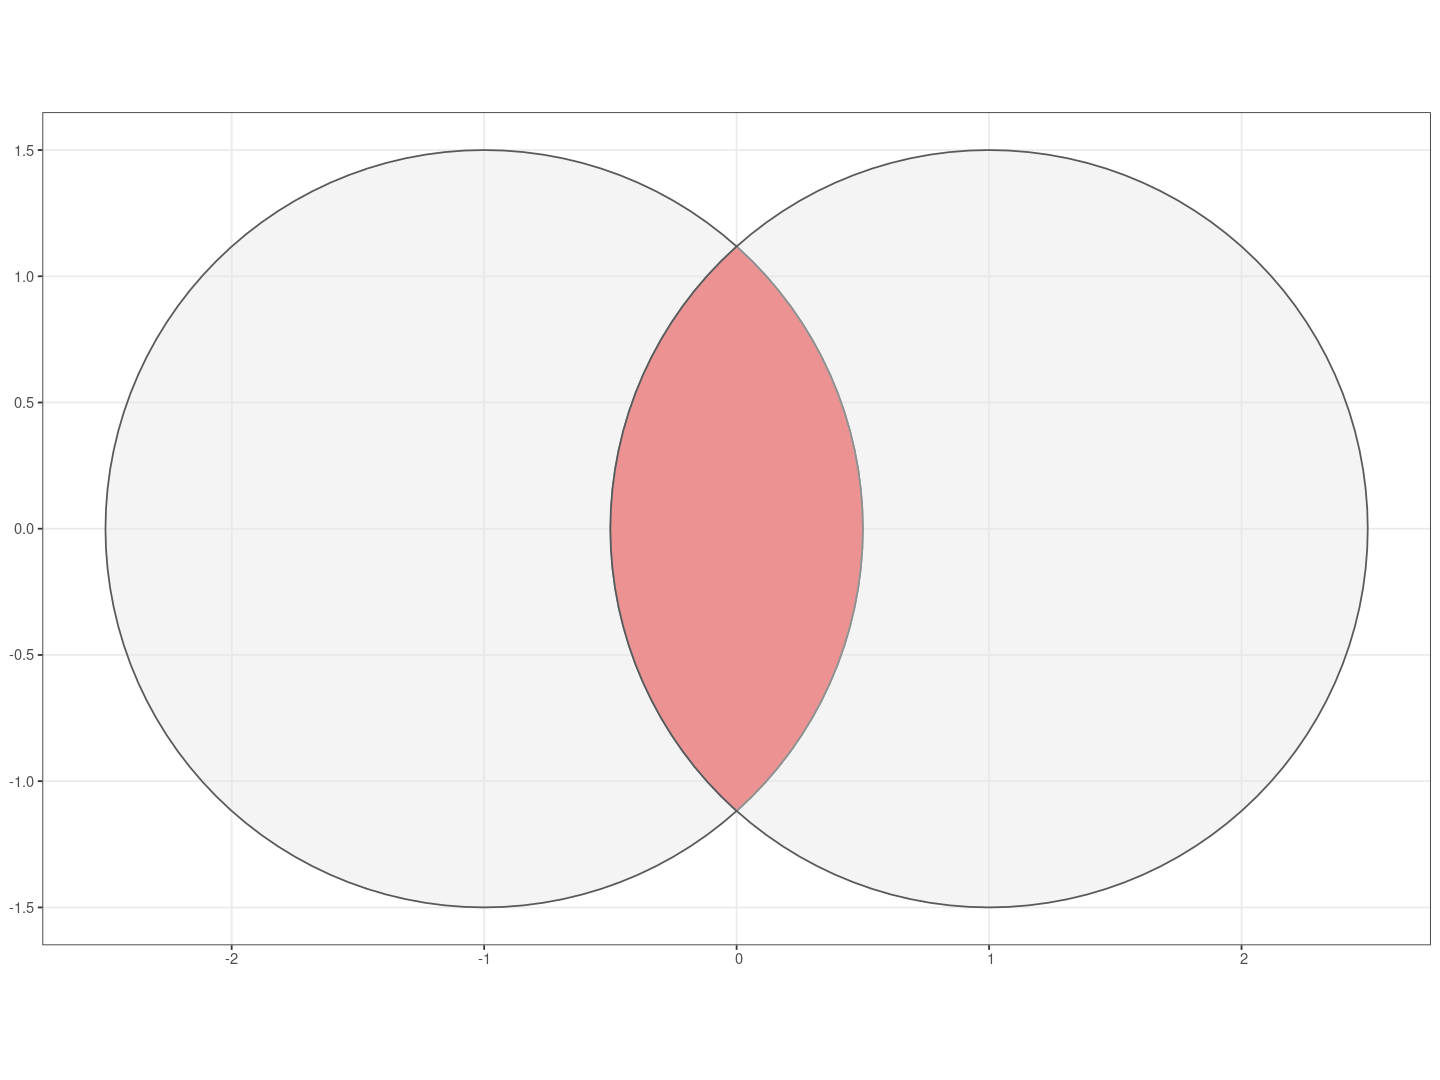

In [41]:
circles[1,] %>%
    st_intersection(circles[2,]) %>%
    ggplot() +
    theme_bw() +
    geom_sf(fill='red') +
    geom_sf(data=circles, alpha=.4)


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


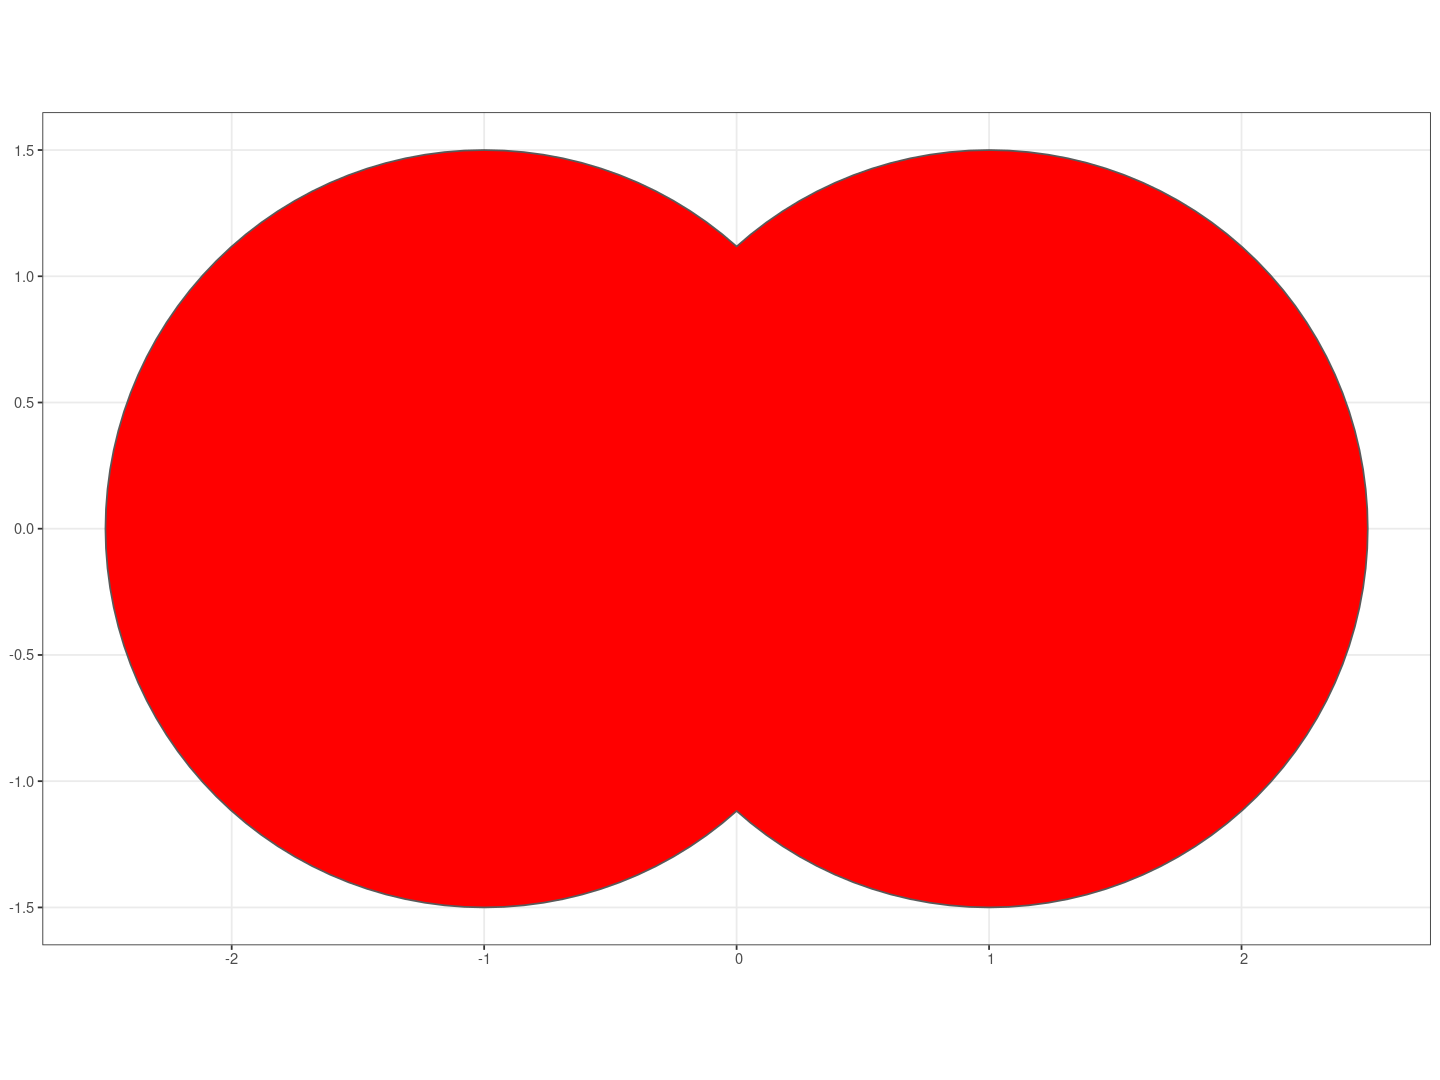

In [42]:
circles[1,] %>%
    st_union(circles[2,]) %>%
    ggplot() +
    theme_bw() +
    geom_sf(fill='red') 


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


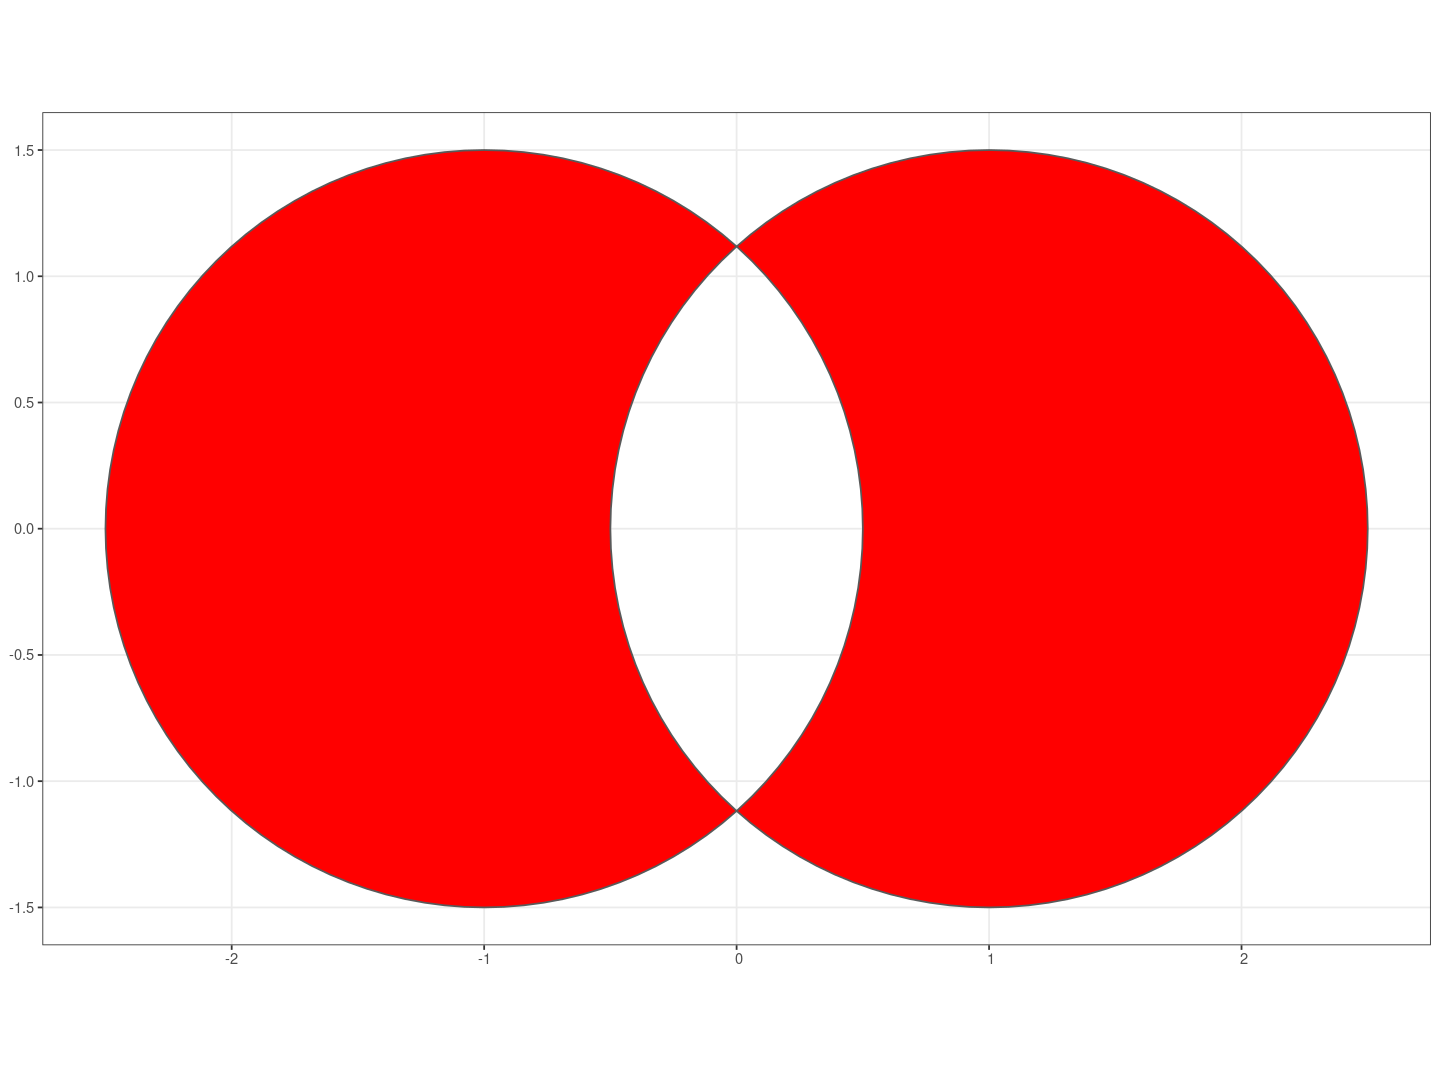

In [43]:
circles[1,] %>%
    st_sym_difference(circles[2,]) %>%
    ggplot() +
    theme_bw() +
    geom_sf(fill='red') 


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


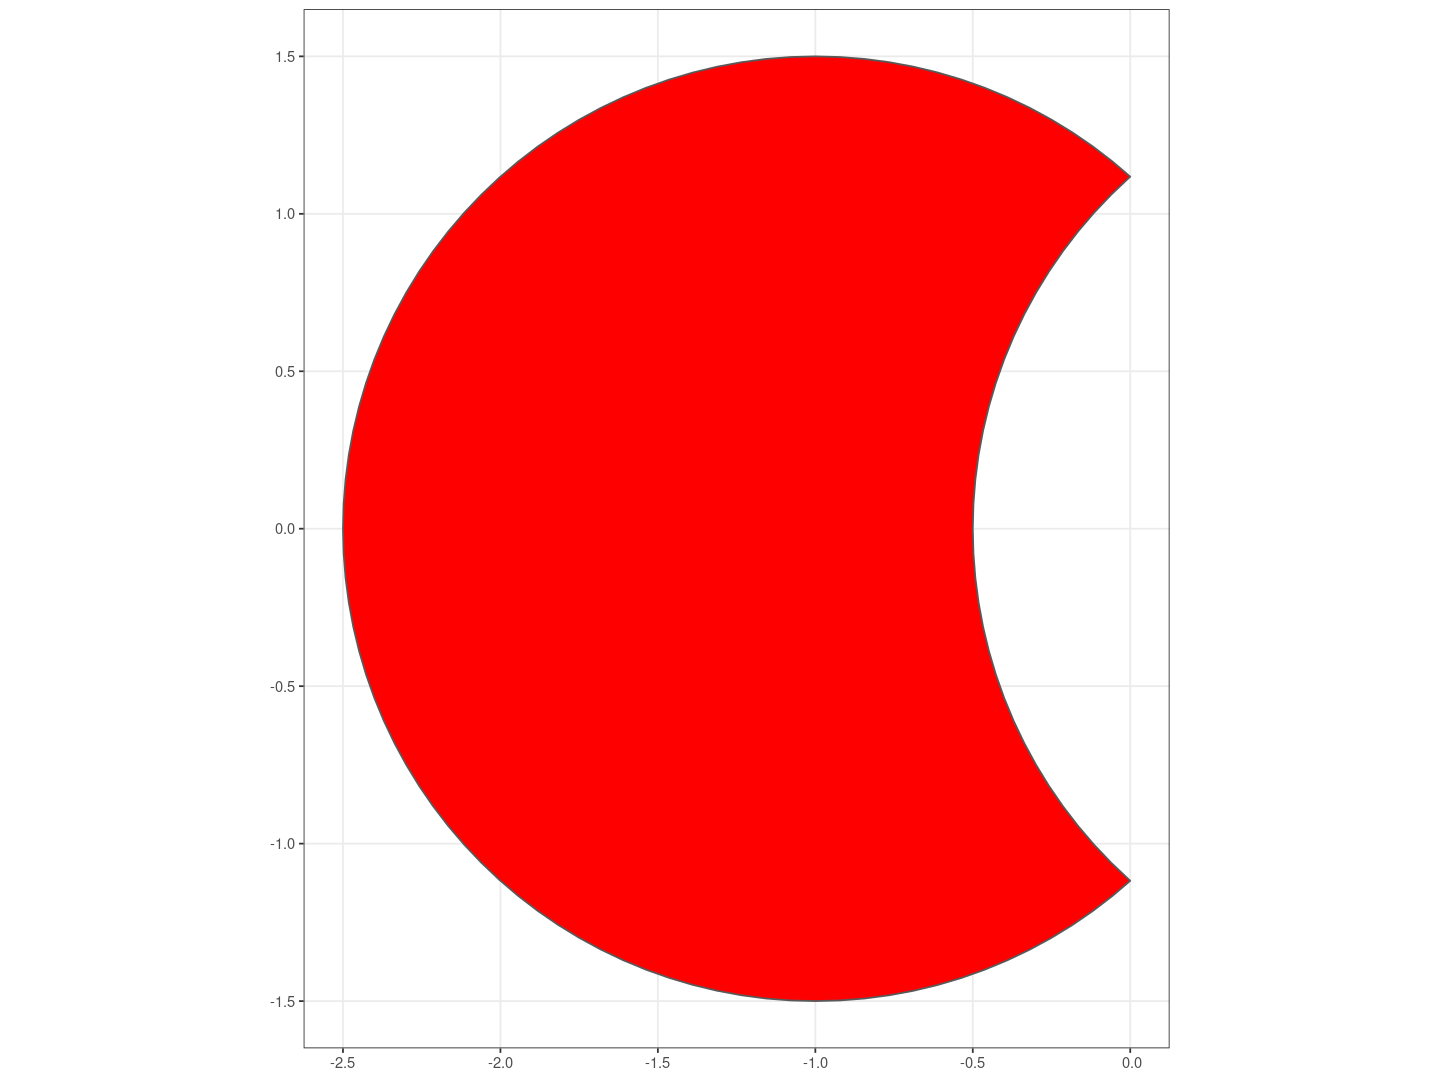

In [44]:
circles[1,] %>%
    st_difference(circles[2,]) %>%
    ggplot() +
    theme_bw() +
    geom_sf(fill='red') 


## Spatial union and data aggregation

When we aggregate data via `group_by` and `summarize`, the geometries of the observations involved are combined via spatial union.

**Example**

In [45]:
world %>%
    group_by(continent) %>%
    summarize(pop = sum(pop, na.rm=T))


continent,pop,geom
<chr>,<dbl>,<GEOMETRY [°]>
Africa,1154946633,MULTIPOLYGON (((43.1453 11....
Antarctica,0,"MULTIPOLYGON (((-180 -89.9,..."
Asia,4311408059,MULTIPOLYGON (((104.37 -1.0...
Europe,669036256,MULTIPOLYGON (((-180 64.979...
North America,565028684,MULTIPOLYGON (((-132.71 54....
Oceania,37757833,MULTIPOLYGON (((-180 -16.55...
Seven seas (open ocean),0,"POLYGON ((68.935 -48.625, 6..."
South America,412060811,MULTIPOLYGON (((-66.95992 -...


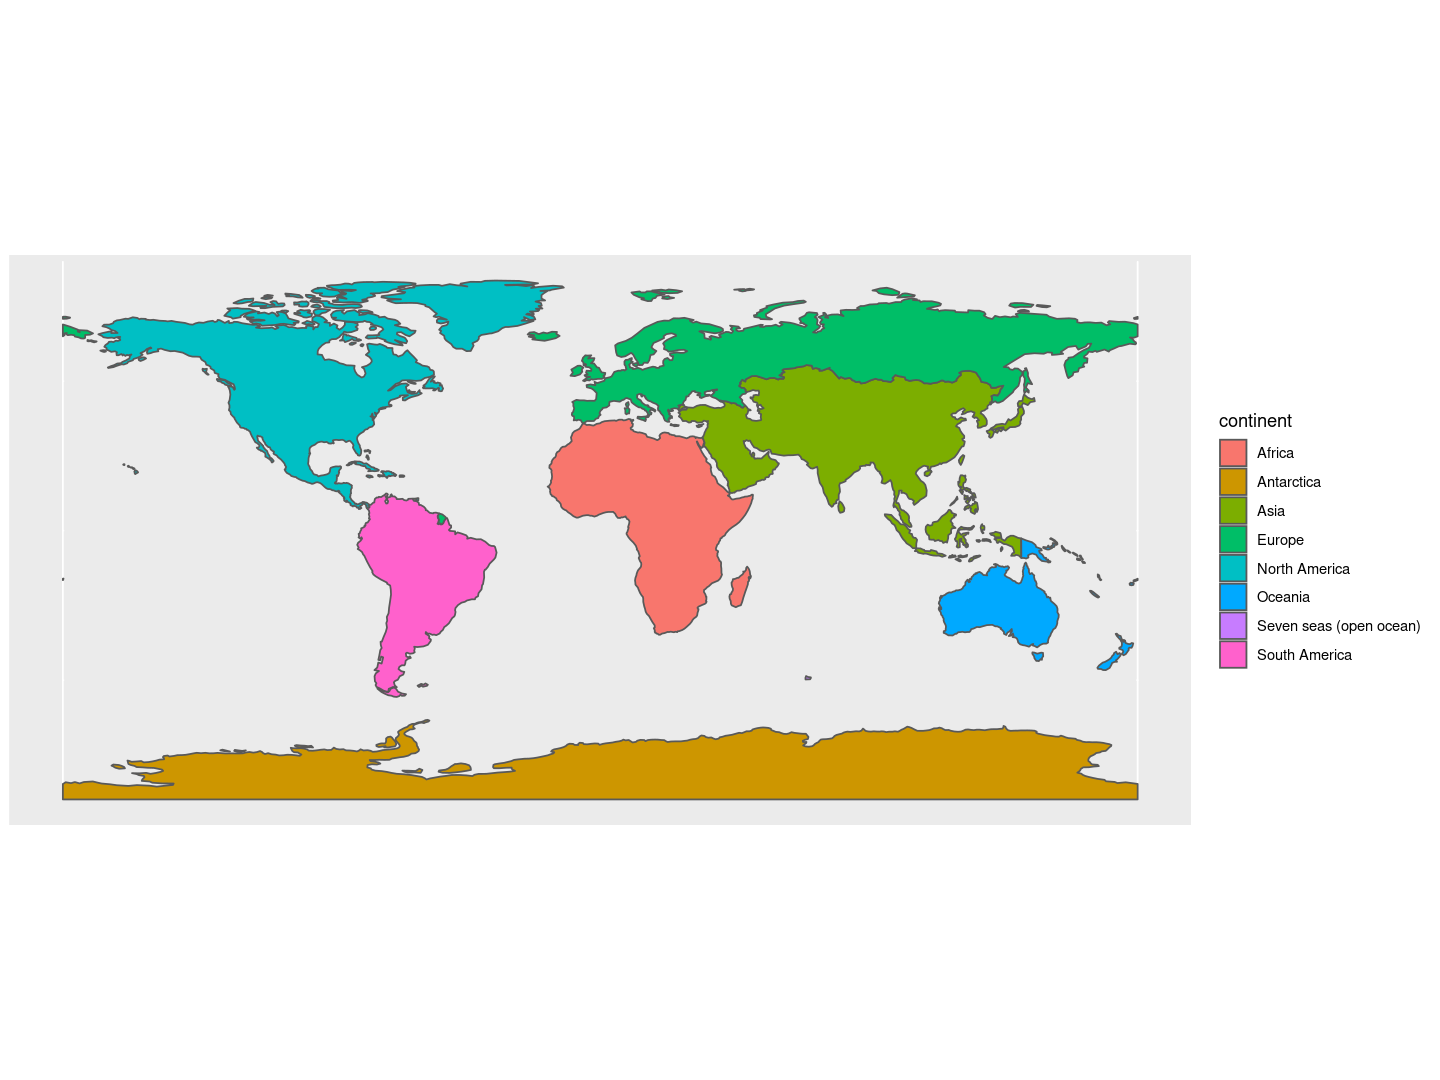

In [46]:
world %>%
    group_by(continent) %>%
    summarize(pop = sum(pop, na.rm=T)) %>%
    ggplot() +
    geom_sf(aes(fill=continent))


## Spatial subsetting

Spatial subsetting is the operation of selection a subset of observations from some dataset on the basis of its spatial relation to some object (or collection of objects).

It can be seen as an extension of the `filter` operation from `tidyverse` with spatial filter criteria.

**Example: High points in New Zealand**

Consider the following two datasets from `spData`:

In [47]:
nz 

Name,Island,Land_area,Population,Median_income,Sex_ratio,geom
<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<MULTIPOLYGON [m]>
Northland,North,12500.5611,175500,23400,0.9424532,MULTIPOLYGON (((1745493 600...
Auckland,North,4941.5726,1657200,29600,0.9442858,MULTIPOLYGON (((1803822 590...
Waikato,North,23900.0364,460100,27900,0.9520500,MULTIPOLYGON (((1860345 585...
Bay of Plenty,North,12071.1447,299900,26200,0.9280391,MULTIPOLYGON (((2049387 583...
Gisborne,North,8385.8266,48500,24400,0.9349734,MULTIPOLYGON (((2024489 567...
Hawke's Bay,North,14137.5244,164000,26100,0.9238375,MULTIPOLYGON (((2024489 567...
Taranaki,North,7254.4804,118000,29100,0.9569363,MULTIPOLYGON (((1740438 571...
Manawatu-Wanganui,North,22220.6084,234500,25000,0.9387734,MULTIPOLYGON (((1866732 566...
Wellington,North,8048.5528,513900,32700,0.9335524,MULTIPOLYGON (((1881590 548...


In [48]:
nz_height %>%
    slice_sample(n=10)

t50_fid,elevation,geometry
<int>,<int>,<POINT [m]>
2372222,3078,POINT (1365305 5168284)
2354404,2820,POINT (1234725 5048309)
2364007,2913,POINT (1379994 5170215)
2372301,3497,POINT (1370422 5172432)
2372236,3724,POINT (1369318 5169132)
2372241,3048,POINT (1361266 5158749)
2364166,2782,POINT (1383006 5181085)
2364344,2875,POINT (1404375 5184714)
2364241,3054,POINT (1383474 5182610)


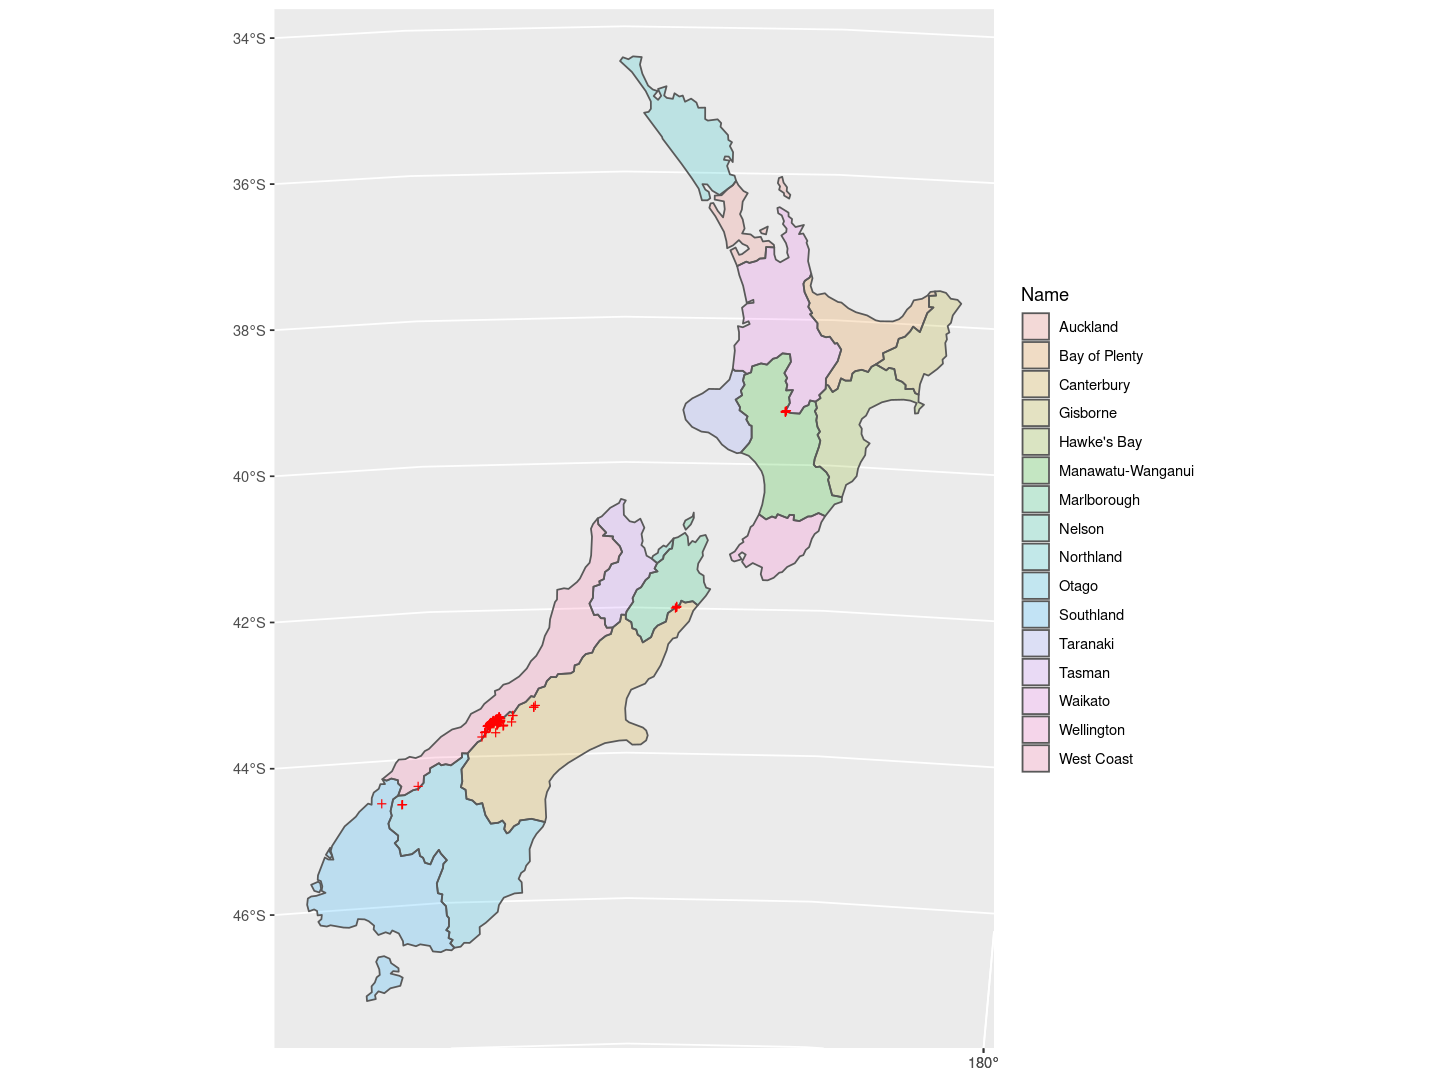

In [49]:
nz %>%
    ggplot() +
    geom_sf(aes(fill=Name), alpha=0.2) +
    geom_sf(data=nz_height, col='red', pch=3)


We want to find all high elevation points within the region *Canterbury*.

In [50]:
canterbury <- nz %>%
    filter(Name == "Canterbury")
canterbury


,Name,Island,Land_area,Population,Median_income,Sex_ratio,geom
,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<MULTIPOLYGON [m]>
1,Canterbury,South,44504.5,612000,30100,0.9753265,MULTIPOLYGON (((1686902 535...


In [51]:
st_intersects(nz_height, canterbury, sparse=F)


FALSE
FALSE
FALSE
FALSE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


In [52]:
canterbury_height <- nz_height %>%
    filter(st_intersects(x=., y=canterbury, sparse=F))


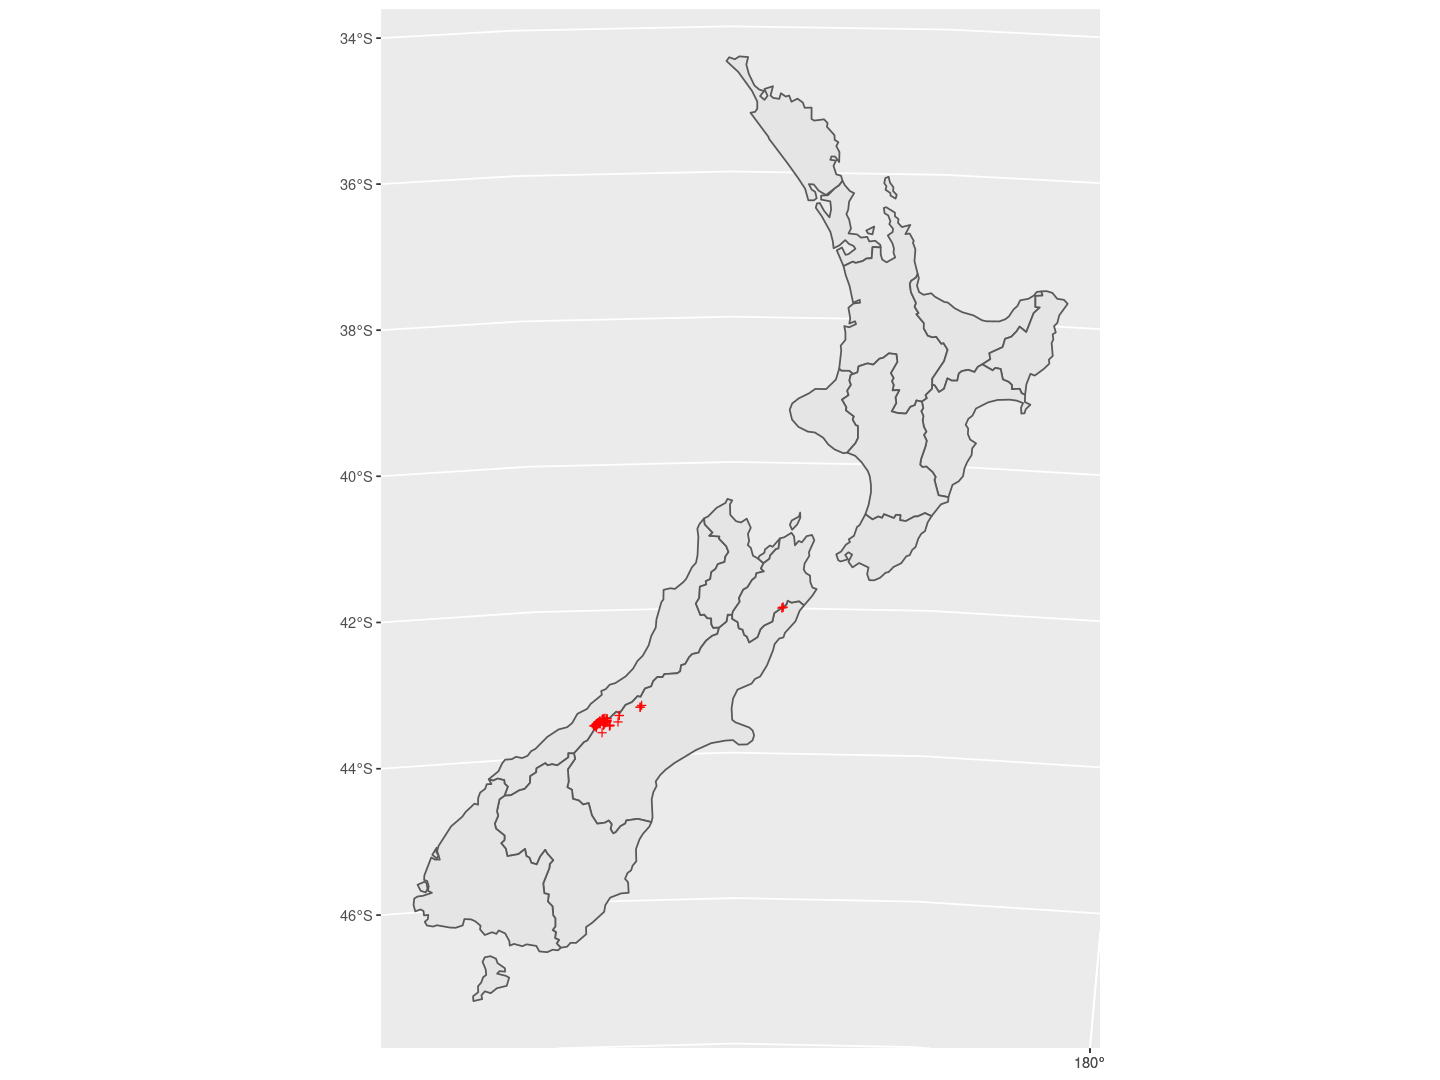

In [53]:
nz %>% 
    ggplot() +
    geom_sf() +
    geom_sf(data=canterbury_height, col='red', pch=3)

The same method can be applied with other geometric relations as well.

## Interactive tasks

Canterbury is the region of New Zealand containing most of the 100 highest points in the country. How many of these high points does the Canterbury region contain?
